# Exploratory Data Analysis - PySpark

Análise Exploratória dos Dados do ENEM entre 2017 e 2019. Não serão plotados mapas coropléticos neste notebook, porém serão gerados arquivos .csv para a confecção de tais mapas em outro software ou notebook a fim de evitar a sobrecarga deste.

# Setup

In [ ]:
# Necessário REINICIAR o Ambiente de Execução após instalar a execução desta célula!
!pip install plotly==4.14.3 # Versão mais recente e com suporte a geojson
!pip install -U kaleido     # Engine para exportar imagens estáticas no plotly
#!pip install geopandas      # Biblioteca manipulação de dados geométricos
!sudo apt update            # Atualizando apt para obter java

Instalando PySpark

In [1]:
# instalando as dependências    -- leva uns minutinhos
!apt-get install openjdk-8-jdk-headless -qq > /dev/null   # Instalando Java
!wget -q !wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz # Download Apache Spark
!tar xf spark-3.1.2-bin-hadoop3.2.tgz   # Descompactando a pasta do Apache Spark
!pip install -q findspark               # Instalando módulo para "achar" o Spark
!pip install -q pyspark                 # Instalando a API do Spark para Python

     |████████████████████████████████| 212.4 MB 59 kB/s 
     |████████████████████████████████| 198 kB 61.6 MB/s 


In [2]:
# configurar as variáveis de ambiente
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"

# tornar o pyspark "importável"
import findspark
findspark.init('spark-3.1.2-bin-hadoop3.2')

# Criando sessão spark
from pyspark.sql import SparkSession
sc = SparkSession.builder.master('local[*]').getOrCreate()

Montando o Google Drive

In [ ]:
## ATENÇÃO! Aparecerá um link externo seguro provido automaticamente pelo Google Colab para que seja 
## gerado o código de autenticação necessário para o acesso ao Drive.

if not os.path.exists('/content/drive'):
  from google.colab import drive
  drive.mount('/content/drive')

# Data Collecting

Coletando os dados pré-processados de cada ano

In [3]:
# download do http para arquivo local
last_year = 2019
data_path = [f'/content/drive/MyDrive/Colab Notebooks/IC_Data_Science_ENEM/Dados/PRE_PROCESSED_ENEM_{anos}.pq' \
             for anos in range(2017, last_year+1)]
data_path

['/content/drive/MyDrive/Colab Notebooks/IC_Data_Science_ENEM/Dados/PRE_PROCESSED_ENEM_2017.pq',
 '/content/drive/MyDrive/Colab Notebooks/IC_Data_Science_ENEM/Dados/PRE_PROCESSED_ENEM_2018.pq',
 '/content/drive/MyDrive/Colab Notebooks/IC_Data_Science_ENEM/Dados/PRE_PROCESSED_ENEM_2019.pq']

In [4]:
# carregar dados pré-processados do ENEM
df = sc.read.parquet(*data_path, inferSchema=True, header=True, encoding='latin-1').drop('Q026', 'Q027')

In [5]:
# Total de linhas
from pyspark.sql.functions import count
df.count()

16850882

# Exploratory Data Analysis

In [6]:
import plotly as py
from plotly.offline import iplot
import plotly.graph_objs as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import math
import numpy as np
import pandas as pd
from scipy.stats import shapiro, anderson, normaltest, levene
#import geopandas as gpd
from pyspark.sql.functions import col, sum, mean

## Inscritos

Verificando o número de inscritos por UF

In [ ]:
# Agrupando o número de inscritos por UF e ano
inscritos_ufs = df.groupby('SG_UF_PROVA', 'CO_UF_PROVA') \
.pivot('NU_ANO') \
.count() \
.toPandas()

In [ ]:
# Organizando o DataFrame 
inscritos_ufs['Total'] = inscritos_ufs[['2017', '2018', '2019']].sum(axis=1)

inscritos_ufs = inscritos_ufs.sort_values('Total', ascending=False) \
.reset_index(drop=True)

In [ ]:
# MODIFICAR ESSA PARTE (talvez)

# Criando mapa de UF e respectiva região
uf_centroeste = ['DF', 'GO', 'MS', 'MT']
uf_nordeste   = ['AL', 'BA', 'CE', 'MA', 'PB', 'PE', 'PI', 'RN', 'SE']
uf_norte      = ['AC', 'AM', 'AP', 'PA', 'RO', 'RR', 'TO']
uf_sudeste    = ['ES', 'MG', 'RJ', 'SP']
uf_sul        = ['PR', 'RS', 'SC']

map_uf_regiao = {
    **dict.fromkeys(uf_centroeste, 'Centro-Oeste'), 
    **dict.fromkeys(uf_nordeste, 'Nordeste'),
    **dict.fromkeys(uf_norte, 'Norte'),
    **dict.fromkeys(uf_sudeste, 'Sudeste'),
    **dict.fromkeys(uf_sul, 'Sul')
}

In [ ]:
inscritos_ufs['Regiao'] = inscritos_ufs['SG_UF_PROVA'].map(map_uf_regiao)
inscritos_ufs.head()

,SG_UF_PROVA,CO_UF_PROVA,2017,2018,2019,Total,Regiao
0,SP,35,1096327,904576,815992,2816895,Sudeste
1,MG,31,703482,565369,534627,1803478,Sudeste
2,BA,29,468945,381664,395436,1246045,Nordeste
3,RJ,33,427101,371190,339718,1138009,Sudeste
4,CE,23,352423,315880,294984,963287,Nordeste


Exportando o dataframe em csv para ser construído o choropleth

In [ ]:
csv_file = 'inscritos_uf'
csv_path = f'/content/drive/MyDrive/Colab Notebooks/IC_Data_Science_ENEM/Mapas/CSV/{csv_file}.csv'
inscritos_ufs.to_csv(csv_path)

Gráfico de Barras

In [ ]:
# Configurações dos dados a serem plotados
data = [
      go.Bar(
          name = 'Inscritos',
          x = inscritos_ufs['SG_UF_PROVA'],
          y = inscritos_ufs['Total'],
          offsetgroup = 0,
          text = inscritos_ufs['Total'],
          textfont={'size': 18}
      ),
]

layout=go.Layout(
        title = 'Total de Inscritos no ENEM por Estado entre 2017 e 2019',
        yaxis_title = 'Total de Inscritos',
        xaxis_title = 'Estado'
    )

In [ ]:
# Plot de barras
fig = go.Figure(
    data=data,
    layout=layout
)
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(uniformtext_minsize=10)
fig.show()

In [ ]:
# Salvando Figura
fig_name = 'inscritos_uf_bar'
fig_folder = 'Inscritos'
fig_path = f'/content/drive/MyDrive/Colab Notebooks/IC_Data_Science_ENEM/Imagens/{fig_folder}/{fig_name}.png'
fig.write_image(fig_path)

Verificando número de inscritos por Região do Brasil

In [ ]:
## Inscritos por Macrorregião
inscritos_reg = inscritos_ufs.groupby(inscritos_ufs['Regiao']) \
[['2017', '2018', '2019', 'Total']].sum() 
inscritos_reg

,2017,2018,2019,Total
Regiao,,,,
Centro-Oeste,537373,445516,424357,1407246
Nordeste,2140022,1743626,1740957,5624605
Norte,749195,582431,596869,1928495
Sudeste,2359723,1949534,1792610,6101867
Sul,673287,574905,540477,1788669


In [ ]:
fig = go.Figure()

fig.add_trace(
    go.Bar(
        name = '2017',
        x = inscritos_reg.index,
        y = inscritos_reg['2017'],
        offsetgroup = 0,
        text = inscritos_reg['2017'],
        texttemplate='<b>%{text:.2s}</b>', 
        textposition='inside', 
        textfont=dict(color='white', size=18),
        marker_color = '#1a936f'
    )
)
fig.add_trace(
    go.Bar(
        name = '2018',
        x = inscritos_reg.index,
        y = inscritos_reg['2018'],
        offsetgroup = 1,
        text = inscritos_reg['2018'],
        texttemplate='<b>%{text:.2s}</b>', 
        textposition='inside', 
        textfont=dict(color='white', size=18),
        marker_color = '#013a63',
    )
)
fig.add_trace(
    go.Bar(
        name = '2019',
        x = inscritos_reg.index,
        y = inscritos_reg['2019'],
        offsetgroup = 2,
        text = inscritos_reg['2019'],
        texttemplate='<b>%{text:.2s}</b>', 
        textposition='inside', 
        textfont=dict(color='white', size=18),
        marker_color = 'rgb(230, 57, 70, 1)'
    )
)

fig.update_layout(
    title = dict(
        text = 'Inscritos no ENEM por Região entre os Anos de 2017 e 2019',
        font = dict(size=24),
    ),
    legend = dict(
        font=dict(size=18),
        title = dict(
            text = 'Ano',
            font = dict(size=20)
        ),
        xanchor='right',
        x=0.99,
        yanchor='top',
        y=0.99
    ),
    yaxis = dict(
        title = dict(
            text='Número de Inscritos',
            font = dict(size = 20),
        ),
        tickfont = dict(size = 18),
        showgrid = True,
        gridcolor = '#BCCCDC'
    ),
    xaxis = dict(
        title = dict(
            text='Região',
            font=dict(size = 20),
        ),
        tickfont = dict(size = 18),
        linecolor = '#BCCCDC'
    ),
    autosize=True,        
    margin={'l': 1, 'r': 1, 't': 35, 'b': 1},
    plot_bgcolor = 'white',
)

fig.show()

In [ ]:
# Salvando Figura
fig_name = 'inscritos_reg_bar_2'
fig_folder = 'Inscritos'
fig_path = f'/content/drive/MyDrive/Colab Notebooks/IC_Data_Science_ENEM/Imagens/{fig_folder}/{fig_name}.png'
fig.write_image(fig_path)

Inscritos entre as cidades de Minas Gerais

In [ ]:
## Inscritos por cidade
inscritos_mg = df.groupBy('SG_UF_PROVA', 'NO_MUNICIPIO_PROVA', 'CO_MUNICIPIO_PROVA') \
.pivot('NU_ANO') \
.count() \
.where(col('SG_UF_PROVA') == 'MG') \
.toPandas()

In [ ]:
int_cols = ['2017', '2018', '2019']
inscritos_mg[int_cols] = inscritos_mg[int_cols].fillna(0)
inscritos_mg[int_cols] = inscritos_mg[int_cols].astype(int)

In [ ]:
inscritos_mg['Total'] = inscritos_mg[['2017', '2018', '2019']].sum(axis=1)
inscritos_mg = inscritos_mg.sort_values('Total', ascending=False) \
.reset_index(drop=True)

In [ ]:
inscritos_mg.head()

,SG_UF_PROVA,NO_MUNICIPIO_PROVA,CO_MUNICIPIO_PROVA,2017,2018,2019,Total
0,MG,Belo Horizonte,3106200,116782,95618,87365,299765
1,MG,Uberlândia,3170206,27466,22898,22885,73249
2,MG,Montes Claros,3143302,26693,20231,19359,66283
3,MG,Contagem,3118601,23856,18866,16896,59618
4,MG,Juiz de Fora,3136702,23070,18759,17622,59451


In [ ]:
# Verificando se há repetição de cidades
inscritos_mg.shape, len(inscritos_mg['CO_MUNICIPIO_PROVA'].unique())

((190, 7), 190)

In [ ]:
# Configurações dos dados a serem plotados
data = [
      go.Bar(
          name = 'Inscritos',
          x = inscritos_mg['NO_MUNICIPIO_PROVA'].head(20),
          y = inscritos_mg['Total'],
          offsetgroup = 0,
          text = inscritos_mg['Total']
      ),
]

layout=go.Layout(
        title = 'Total de Inscritos no ENEM em 20 Cidades de Minas Gerais entre 2017 e 2019',
        yaxis_title = 'Total de Inscritos',
        xaxis_title = 'Estado'
    )

In [ ]:
# Plot de barras
fig = go.Figure(
    data=data,
    layout=layout
)
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.show()

In [ ]:
# Salvando Figura
fig_name = 'inscritos_mg_bar'
fig_folder = 'Inscritos'
fig_path = f'/content/drive/MyDrive/Colab Notebooks/IC_Data_Science_ENEM/Imagens/{fig_folder}/{fig_name}.png'
fig.write_image(fig_path)

In [ ]:
# Configurações dos dados a serem plotados
data = [
      go.Bar(
          name = '2017',
          x = inscritos_mg['NO_MUNICIPIO_PROVA'].head(10),
          y = inscritos_mg['2017'],
          offsetgroup = 0,
          text = inscritos_mg['2017'],
      ),
      go.Bar(
          name = '2018',
          x = inscritos_mg['NO_MUNICIPIO_PROVA'].head(10),
          y = inscritos_mg['2018'],
          offsetgroup = 1,
          text = inscritos_mg['2018'],
      ),
      go.Bar(
          name = '2019',
          x = inscritos_mg['NO_MUNICIPIO_PROVA'].head(10),
          y = inscritos_mg['2019'],
          offsetgroup = 2,
          text = inscritos_mg['2019'],
      ),
]

# Aprimorar Layout!
layout=go.Layout(
        title = 'Inscritos no ENEM por Município e Ano de Minas Gerais (10 principais)',
        yaxis_title = 'Número de Inscritos',
        xaxis_title = 'Cidades'
    )

In [ ]:
# Plot de barras
fig = go.Figure(
    data=data,
    layout=layout
)
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.show()

In [ ]:
# Salvando Figura
fig_name = 'inscritos_ano_mg_bar'
fig_folder = 'Inscritos'
fig_path = f'/content/drive/MyDrive/Colab Notebooks/IC_Data_Science_ENEM/Imagens/{fig_folder}/{fig_name}.png'
fig.write_image(fig_path)

## Desistentes

Taxa de desistência por Unidade Federativa 

In [ ]:
# Agrupando a presença separado por ano para cada estadp
presenca = df.groupby('SG_UF_PROVA', 'CO_UF_PROVA', 'TP_PRESENCA') \
.pivot('NU_ANO') \
.agg(count(col('TP_PRESENCA')))

In [ ]:
# Separando os ausentes de cada estado todo ano
ausentes = presenca.where(col('TP_PRESENCA')==0).toPandas()
ausentes.head()

,SG_UF_PROVA,CO_UF_PROVA,TP_PRESENCA,2017,2018,2019
0,GO,52,0,72931,54152,46314
1,PI,22,0,40593,24591,27147
2,SC,42,0,38701,34055,30837
3,PA,15,0,107700,67774,72973
4,MG,31,0,235745,153671,144542


In [ ]:
# Separando os presentes de cada estado todo ano
presentes = presenca.where(col('TP_PRESENCA')==1).toPandas()

# Reordenando de acordo com a ordem de SG_UF_PROVA do dataframe de ausentes
# para não bagunçar o gráfico
presentes = presentes.set_index('SG_UF_PROVA')
presentes = presentes.reindex(index=ausentes['SG_UF_PROVA'])
presentes = presentes.reset_index()

presentes.head()

,SG_UF_PROVA,CO_UF_PROVA,TP_PRESENCA,2017,2018,2019
0,GO,52,1,138546,129337,123669
1,PI,22,1,103487,90715,95189
2,SC,42,1,82593,84765,79862
3,PA,15,1,227057,199064,206623
4,MG,31,1,467737,411698,390085


In [ ]:
desistencia = ausentes[['SG_UF_PROVA', 'CO_UF_PROVA']]
anos = ['2017', '2018', '2019']
for ano in anos:
  desistencia[ano] = np.round(ausentes.loc[:, ano]/(ausentes.loc[:, ano]+presentes.loc[:, ano])*100, decimals=2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
desistencia['Média'] = np.round(np.mean(desistencia[anos], axis=1), 2)
desistencia = desistencia.rename(columns={
    'SG_UF_PROVA': 'Estado',
    'CO_UF_PROVA': 'CodEstado'
}).sort_values('Média', ascending=False) \
.reset_index(drop=True)

In [ ]:
desistencia['Regiao'] = desistencia['Estado'].map(map_uf_regiao)
desistencia.head()

,Estado,CodEstado,2017,2018,2019,Média,Regiao
0,AM,13,44.85,37.40,36.87,39.71,Norte
1,RR,14,41.44,34.03,32.10,35.86,Norte
2,MT,51,39.39,33.68,31.61,34.89,Centro-Oeste
3,MS,50,40.32,32.86,30.70,34.63,Centro-Oeste
4,AP,16,36.87,31.21,29.86,32.65,Norte


Exportando em .csv para construção de choropleth

In [ ]:
csv_file = 'desistentes_uf'
csv_path = f'/content/drive/MyDrive/Colab Notebooks/IC_Data_Science_ENEM/Mapas/CSV/{csv_file}.csv'
desistencia.to_csv(csv_path)

In [ ]:
# Configurações dos dados a serem plotados
fig = go.Figure()

fig.add_trace(
    go.Scatter(
          name = '2017',
          x = desistencia['Estado'],
          y = desistencia['2017'],
          text = desistencia['2017'],
          line=dict(color='red', width=4),
          textposition='bottom center',
          mode='lines+markers',
          marker={'size':10, 'symbol': 200}
      )
)
fig.add_trace(
    go.Scatter(
          name = '2018',
          x = desistencia['Estado'],
          y = desistencia['2018'],
          text = desistencia['2018'],
          line=dict(color='darkorange', width=4),
          textposition='bottom center',
          mode='lines+markers',
          marker={'size':10, 'symbol': 200}
      )
)
fig.add_trace(
    go.Scatter(
          name = '2019',
          x = desistencia['Estado'],
          y = desistencia['2019'],
          text = desistencia['2019'],
          line=dict(color='green', width=4),
          textposition='bottom center',
          mode='lines+markers',
          marker={'size':10, 'symbol': 200}
    )
)
fig.add_trace(
    go.Box(
        name = 'Média',
        x = desistencia['Estado'],
        y = desistencia['Média'],
        text = desistencia['Média'],
        marker_color='blue'
    )
)

fig.add_annotation(x='AM', y=40,
            text='40%',
            font={'size':14, 'color':'darkred'},
            showarrow=True,
            arrowcolor='darkred',
            yshift=10,
)
fig.add_shape(type='rect',
    xref='paper', yref='paper',
    x0=0.035, y0=0,
    x1=0.075, y1=1,
    line=dict(
        color='Salmon',
        width=3,
    ),
    opacity=0.4,
    fillcolor='LightSalmon',
)

fig.update_layout(    
    go.Layout(
          title = 'Índice de Desistência no ENEM por Estado entre 2017 e 2019',
          title_font = {'size': 16},
          yaxis_title = 'Desistência [%]',
          xaxis_title = 'Estado',
    )    
)

fig.update_yaxes(
    title_font=dict(size=14),
    tickfont=dict(size=12), 
    range=[20, 50]
)
fig.update_xaxes(
    title_font=dict(size=14), 
    tickfont=dict(size=12)
)

fig.show()

In [ ]:
# Salvando Figura
fig_name = 'desistencia_uf_scatter'
fig_folder = 'Desistencia'
fig_path = f'/content/drive/MyDrive/Colab Notebooks/IC_Data_Science_ENEM/Imagens/{fig_folder}/{fig_name}.png'
fig.write_image(fig_path)

In [ ]:
## CHOROPLETH

Taxa de desistência por macrorregião do Brasil

In [ ]:
## Desistência por Região
desistencia_reg = desistencia.groupby(desistencia['Regiao']) \
[['2017', '2018', '2019', 'Média']].mean() \
.sort_values('Média', ascending=False)

In [ ]:
desistencia_reg

,2017,2018,2019,Média
Regiao,,,,
Norte,36.948571,31.172857,30.408571,32.845714
Centro-Oeste,36.765000,31.432500,29.772500,32.657500
Sudeste,33.857500,29.232500,28.215000,30.435000
Sul,32.693333,29.723333,28.333333,30.250000
Nordeste,31.006667,25.924444,24.533333,27.155556


In [ ]:
# Configurações dos dados a serem plotados
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        name = '2017',
        x = desistencia_reg.index,
        y = desistencia_reg['2017'],
        text = desistencia_reg['2017'],
        line=dict(color='red', width=4),
        mode='lines+markers',
        marker={'size':10, 'symbol': 200}
    )
)
fig.add_trace(
    go.Scatter(
        name = '2018',
        x = desistencia_reg.index,
        y = desistencia_reg['2018'],
        text = desistencia_reg['2018'],
        line=dict(color='darkorange', width=4),
        mode='lines+markers',
        marker={'size':10, 'symbol': 200}
    )
)
fig.add_trace(
    go.Scatter(
        name = '2019',
        x = desistencia_reg.index,
        y = desistencia_reg['2019'],
        text = desistencia_reg['2019'],
        line=dict(color='green', width=4),
        mode='lines+markers',
        marker={'size':10, 'symbol': 200}
    )
)
fig.add_trace(
    go.Scatter(
        name = 'Média',
        x = desistencia_reg.index,
        y = desistencia_reg['Média'],
        mode='lines+text+markers',
        line=dict(
            color='blue',
            width=2,
            dash='dash',
            shape='spline'),
        text = desistencia_reg['Média'],
        textposition='top center',
        textfont=dict(size=20, color='blue'),
        texttemplate='<b>%{text:.2s}%</b>',
        marker={'size':10, 'symbol': 200}
    )
)


fig.update_layout(    
    go.Layout(
          title = dict(
              text='Desistência no ENEM por Macrorregião entre 2017 e 2019<br>\n',
              font = {'size': 24},
          ),
          yaxis = dict(
              title = dict(
                  text= 'Desistência [%]',
                  font=dict(size=20),
              ),
              tickfont=dict(size=18), 
              range=[20, 40],
              linecolor='#BCCCDC',
          ),
          xaxis = dict(
              title = dict(
                  text='Macrorregião Política',
                  font=dict(size=20)
              ),
              tickfont=dict(size=18),
              linecolor='#BCCCDC'
          ),
          legend = dict(
              font=dict(size=16),
              title=dict(
                  text='Ano',
                  font=dict(size=20)
              ),
              yanchor='top',
              xanchor='right',
              y=0.99,
              x=0.99
          ),
          autosize = True,
          margin={'l': 1, 'r': 10, 't': 35, 'b': 1},
          plot_bgcolor = 'white'
    )    
)

fig.show()

In [ ]:
# Salvando Figura
fig_name = 'desistencia_reg_scatter'
fig_folder = 'Desistencia'
fig_path = f'/content/drive/MyDrive/Colab Notebooks/IC_Data_Science_ENEM/Imagens/{fig_folder}/{fig_name}.png'
fig.write_image(fig_path)

In [ ]:
## CHOROPLETH

Índice de desistência entre as cidades de Minas Gerais

In [ ]:
presenca_mg = df.groupby('NO_MUNICIPIO_PROVA', 'CO_MUNICIPIO_PROVA', 'SG_UF_PROVA', 'TP_PRESENCA') \
.pivot('NU_ANO') \
.agg(count(col('TP_PRESENCA'))) \
.where(col('SG_UF_PROVA')=='MG')

In [ ]:
ausentes_mg = presenca_mg.where(col('TP_PRESENCA')==0).toPandas()
presentes_mg = presenca_mg.where(col('TP_PRESENCA')==1).toPandas()

# Reordenando de acordo com Q001 para não bagunçar o gráfico
presentes_mg = presentes_mg.set_index('NO_MUNICIPIO_PROVA')
presentes_mg = presentes_mg.reindex(index=ausentes_mg['NO_MUNICIPIO_PROVA'])
presentes_mg = presentes_mg.reset_index()

presentes_mg.head()

,NO_MUNICIPIO_PROVA,CO_MUNICIPIO_PROVA,SG_UF_PROVA,TP_PRESENCA,2017,2018,2019
0,Carangola,3113305,MG,1,1862.0,1659.0,1772.0
1,Três Marias,3169356,MG,1,802.0,609.0,538.0
2,Ouro Preto,3146107,MG,1,3157.0,2876.0,2803.0
3,Itacarambi,3132107,MG,1,601.0,486.0,512.0
4,Lontra,3138658,MG,1,888.0,724.0,834.0


In [ ]:
ausentes_mg.head()

,NO_MUNICIPIO_PROVA,CO_MUNICIPIO_PROVA,SG_UF_PROVA,TP_PRESENCA,2017,2018,2019
0,Carangola,3113305,MG,0,828.0,592.0,606.0
1,Três Marias,3169356,MG,0,423.0,208.0,172.0
2,Ouro Preto,3146107,MG,0,1445.0,987.0,1049.0
3,Itacarambi,3132107,MG,0,287.0,264.0,209.0
4,Lontra,3138658,MG,0,396.0,251.0,258.0


In [ ]:
desistencia_mg = ausentes_mg[['NO_MUNICIPIO_PROVA', 'CO_MUNICIPIO_PROVA']]

for ano in anos:
  desistencia_mg[ano] = np.round(ausentes_mg[ano]/(ausentes_mg[ano]+presentes_mg[ano])*100, decimals=2)

desistencia_mg['Média'] = np.round(np.mean(desistencia_mg[anos], axis=1), 2)
desistencia_mg = desistencia_mg.rename(columns={
    'NO_MUNICIPIO_PROVA': 'Município',
    'CO_MUNICIPIO_PROVA': 'CodMunicipio'
}).sort_values('Média', ascending=False) \
.reset_index(drop=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
desistencia_mg.head()

,Município,CodMunicipio,2017,2018,2019,Média
0,Camanducaia,3110509,42.30,NaN,NaN,42.30
1,Extrema,3125101,NaN,39.05,35.12,37.08
2,Nova Serrana,3145208,41.56,32.90,32.53,35.66
3,Ribeirão das Neves,3154606,40.74,29.87,33.45,34.69
4,Belo Oriente,3106309,NaN,33.40,35.50,34.45


## Sexo

In [ ]:
# Visão Geral
df.groupby('TP_SEXO') \
.count() \
.show()

+-------+-------+
|TP_SEXO|  count|
+-------+-------+
|      F|9949413|
|      M|6901469|
+-------+-------+



Verificando Idade

In [ ]:
df.groupby('NU_IDADE') \
.pivot('TP_SEXO') \
.count() \
.show()

+--------+-------+------+
|NU_IDADE|      F|     M|
+--------+-------+------+
|      26| 211898|165413|
|      29| 143558|108698|
|      65|   1053|  1157|
|      54|  11482|  7169|
|      19|1098500|767928|
|      22| 458067|357819|
|      77|     40|    58|
|       7|      9|     6|
|      34|  90856| 61718|
|      50|  19059| 11223|
|      94|      1|  null|
|      57|   6833|  4671|
|      32| 106008| 76141|
|      43|  40544| 23043|
|      84|      6|     6|
|      31| 116679| 85708|
|      39|  61631| 36802|
|      98|      1|  null|
|      25| 252234|197039|
|      71|    208|   277|
+--------+-------+------+
only showing top 20 rows



In [ ]:
from pyspark.ml.feature import Bucketizer

splits = [0, 16, 17, 18, 19, 20, 25, 30, 50, float('Inf')]
bucketizer = Bucketizer(splits=splits,inputCol='NU_IDADE', outputCol="bins_IDADE")
df_buck = bucketizer.setHandleInvalid("keep").transform(df)

df_buck.show()

+------------+------+-----------------------+-----------------------+----------------+----------------+--------+-------+---------------+-----------+----------------+-----------------------+-----------------------+----------------+----------------+---------------+---------------+---------+------------+--------------+------------------+--------------------+-----------+-----------+---------------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+------------------+-----------+----------------------+-------------------+-------------+--------------------+----------+
|NU_INSCRICAO|NU_ANO|CO_MUNICIPIO_RESIDENCIA|NO_MUNICIPIO_RESIDENCIA|CO_UF_RESIDENCIA|SG_UF_RESIDENCIA|NU_IDADE|TP_SEXO|TP_ESTADO_CIVIL|TP_COR_RACA|TP_NACIONALIDADE|CO_MUNICIPIO_NASCIMENTO|NO_MUNICIPIO_NASCIMENTO|CO_UF_NASCIMENTO|SG_UF_NASCIMENTO|TP_ST_CONCLUSAO|TP_ANO_CONCLUIU|TP_ESCOLA|IN_TREINEIRO|IN_SEM_RECURSO|CO_MUNICIPIO_PROVA|  NO_MUNICIPIO_PROVA|

In [ ]:
teste_idade = df_buck.groupby('bins_IDADE') \
.pivot('TP_SEXO') \
.count() \
.toPandas()

In [ ]:
teste_idade = teste_idade.sort_values('bins_IDADE', ascending=True).reset_index(drop=True)
teste_idade

,bins_IDADE,F,M
0,0.0,161207,87292
1,1.0,595728,333640
2,2.0,1614884,1039898
3,3.0,1631663,1109712
4,4.0,1098500,767928
5,5.0,2496844,1914627
6,6.0,948152,732460
7,7.0,1275656,831048
8,8.0,126779,84864


In [ ]:
bins_idade_map = {
    0.0: '0 a 15 anos',
    1.0: '16 anos',
    2.0: '17 anos',
    3.0: '18 anos',
    4.0: '19 anos',
    5.0: '20 a 24 anos',
    6.0: '25 a 29 anos',
    7.0: '30 a 49 anos',
    8.0: 'Mais de 50 anos',
}

In [ ]:
fig = go.Figure()

fig.add_trace(
    go.Bar(
        name = 'Feminino',
        x = teste_idade['F'],
        y = teste_idade['bins_IDADE'].map(bins_idade_map),
        offsetgroup = 1,
        text = teste_idade['bins_IDADE'],
        marker = dict(color = 'rgb(230, 57, 70, 1)'),
        orientation='h'
    )
)
fig.add_trace(
    go.Bar(
        name = 'Masculino',
        x = teste_idade['M'],
        y = teste_idade['bins_IDADE'].map(bins_idade_map),
        offsetgroup = 0,
        text = teste_idade['bins_IDADE'],
        marker = dict(color = 'rgb(29, 53, 87, 1)'),
        orientation='h'
    )
)
      
fig.update_layout(
    title = dict(
        text='Distribuição de Inscritos do ENEM entre 2017 e 2019<br>por Gênero em cada Faixa Etária',
        font=dict(size=24)
    ),
    yaxis = dict(
        title = dict(
            text='Grupo de Idade',
            font=dict(size=20)
        ),
        tickfont = dict(size=18)
    ),
    xaxis = dict(
        title = dict(
            text='Quantidade de Inscritos',
            font=dict(size=20)
        ),
        tickfont = dict(size=18),
        showgrid=True,
        gridcolor='#BCCCDC'
    ),
    legend=dict(
        font=dict(size=16),
        title=dict(
            text='Sexo Autodeclarado',
            font=dict(size=18)
        ),
        xanchor='right',
        x=0.99,
        yanchor='top',
        y=0.99
    ),
    autosize=True,
    margin=dict(l=1, r=10, t=70, b=5),
    plot_bgcolor='white',
)

fig.show()

In [ ]:
# Salvando Figura
fig_name = 'sexo_idade_hbar'
fig_folder = 'Sexo'
fig_path = f'/content/drive/MyDrive/Colab Notebooks/IC_Data_Science_ENEM/Imagens/{fig_folder}/{fig_name}.png'
fig.write_image(fig_path)

Realizando uma amostra estratificada dos inscritos do ENEM, mantendo a proporção da variável TP_SEXO

In [ ]:
# Configurando o tamanho da amostra para 10% do tamanho da população
# estratificado pela variável TP_SEXO
fractions = {'M': 0.1, 'F': 0.1}

# Coletando amostra estratificada somente no ano de 2019
# para garantir a independência das amostras
smp_TP_SEXO = df[df['NU_ANO']=='2019'].sampleBy(col('TP_SEXO'), fractions=fractions, seed=0)
smp_TP_SEXO.count()

509214

In [ ]:
tpsexo_df = smp_TP_SEXO['TP_SEXO', 'TP_PRESENCA', 'NU_NOTA_MEDIA'].toPandas()
tpsexo_df['TP_SEXO'].value_counts()

F    303284
M    205930
Name: TP_SEXO, dtype: int64

In [ ]:
# Mapeando a variável TP_SEXO
tpsexo_df['TP_SEXO'] = tpsexo_df['TP_SEXO'].map({'M': 'Masculino', 'F': 'Feminino'})

In [ ]:
# Pie Chart - TP_SEXO

labels = tpsexo_df['TP_SEXO'].unique().tolist()
values = [tpsexo_df['TP_SEXO'].loc[tpsexo_df['TP_SEXO']==label].count() for label in labels]

data=[
      go.Pie(
          labels=labels, 
          values=values,
          pull=[0.01, 0.01],
          hole=.3,
          textinfo='label+value+percent',
          texttemplate = '<b>%{label}:<br>%{value:.2s} <br>(%{percent})</b>',
          textfont={'size':20, 'color': ['white', 'white']},
          marker_colors=['rgb(29, 53, 87, 1)', 'rgb(230, 57, 70, 1)']
      )
]

fig = go.Figure(data=data)

fig.update_layout(
    title = dict(
        text = 'Distribuição do Sexo Declarado pelos Inscritos do ENEM<br>',
        xanchor = 'auto',
        yanchor = 'top',
        font = dict(size=24)
    ),
    legend = dict(
        font=dict(size=16),
        title = dict(
            text = 'Sexo',
            font = dict(size=20)
        )
    ),
    autosize = True,
    margin = {'t':35, 'l':5, 'r':5, 'b':5},
    showlegend=True,
)

fig.show()

In [ ]:
# Salvando Figura
fig_name = 'sexo_donut'
fig_folder = 'Sexo'
fig_path = f'/content/drive/MyDrive/Colab Notebooks/IC_Data_Science_ENEM/Imagens/{fig_folder}/{fig_name}.png'
fig.write_image(fig_path)

Razão de desistência por gênero

In [ ]:
tpsexo_df['TP_PRESENCA'] = tpsexo_df['TP_PRESENCA'].map({0: 'Ausente', 1: 'Presente'})

In [ ]:
from plotly.subplots import make_subplots

In [ ]:
# Pie plots
fig = make_subplots(
    rows=1, cols=2,
    specs=[[{'type':'domain'}, {'type':'domain'}]])

fig.add_trace(
    go.Pie(
        labels = tpsexo_df['TP_PRESENCA'].unique().tolist(), 
        values = tpsexo_df['TP_PRESENCA'].loc[tpsexo_df['TP_SEXO']=='Masculino'].value_counts().tolist(),
        hole=.3,
        pull=[0.0, 0.05],
        textinfo='label+percent',
        texttemplate='<b>%{label}<br>%{percent}</b>',
        textfont={'size':18, 'color': ['black', 'white']},
        marker_colors=['lightblue', 'darkblue'],
        title='Sexo Masculino<br>\n',
        titleposition='top center',
        titlefont={'size':20},        
    ), 1, 1
)
fig.add_trace(
    go.Pie(
        labels = tpsexo_df['TP_PRESENCA'].unique().tolist(), 
        values = tpsexo_df['TP_PRESENCA'].loc[tpsexo_df['TP_SEXO']=='Feminino'].value_counts().tolist(),
        hole=.3,
        pull=[0.0, 0.05],
        textinfo='label+percent',
        texttemplate='<b>%{label}<br>%{percent}</b>',
        textfont={'size':18, 'color': ['black', 'white']},
        marker_colors=['lightsalmon', 'darkred'],
        title='Sexo Feminino<br>\n',
        titleposition='top center',
        titlefont={'size':20}
    ), 1, 2
)

fig.update_layout(
    title = dict(
        text='Razão de Desistência por Gênero dos Inscritos do ENEM',
        font=dict(size=24)
    ),
    showlegend=False,
    autosize=True,
    margin={'l':5, 'b':5, 't':35, 'r':5}
)

fig.show()

In [ ]:
# Salvando Figura
fig_name = 'sexo_desistencia_donuts'
fig_folder = 'Sexo'
fig_path = f'/content/drive/MyDrive/Colab Notebooks/IC_Data_Science_ENEM/Imagens/{fig_folder}/{fig_name}.png'
fig.write_image(fig_path)

### Visualização Estatística

In [ ]:
tpsexo_presentes = tpsexo_df.loc[tpsexo_df['TP_PRESENCA']=='Presente']

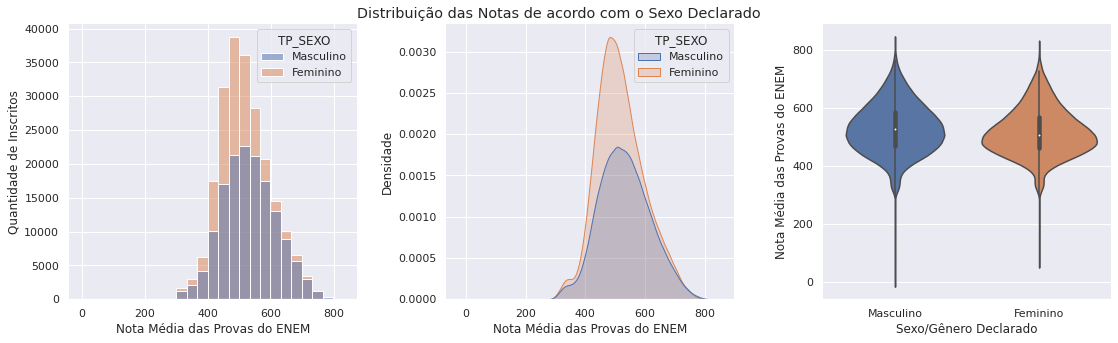

In [ ]:
f, axes = plt.subplots(1, 3, figsize=(16, 5))
sns.despine(left=True, top=True)
f.suptitle('Distribuição das Notas de acordo com o Sexo Declarado')

# Histograma comparando a distribuição de notas entre homens e mulheres
sns.histplot(
    x=tpsexo_presentes['NU_NOTA_MEDIA'],
    hue=tpsexo_presentes['TP_SEXO'],
    bins=25, 
    kde=False,
    ax=axes[0]
)
axes[0].set_title('')
axes[0].set_xlabel('Nota Média das Provas do ENEM')
axes[0].set_ylabel('Quantidade de Inscritos')
#axes[0].legend(['Feminino', 'Masculino'])

# Estimativa de Densidade de Kernel (KDE) entre as notas de homens e mulheres
sns.kdeplot(
    x=tpsexo_presentes['NU_NOTA_MEDIA'], 
    hue=tpsexo_presentes['TP_SEXO'],
    fill=True,
    shade=True,
    ax=axes[1]
)
axes[1].set_title('')
axes[1].set_xlabel('Nota Média das Provas do ENEM')
axes[1].set_ylabel('Densidade')
#axes[1].legend(['Feminino', 'Masculino'])

# Plot "violino"
sns.violinplot(
    y=tpsexo_presentes['NU_NOTA_MEDIA'],
    x=tpsexo_presentes['TP_SEXO'],
    ax=axes[2]
)
axes[2].set_title('')
axes[2].set_xlabel('Sexo/Gênero Declarado')
axes[2].set_ylabel('Nota Média das Provas do ENEM')
#axes[2].set_xticklabels(['Masculino', 'Feminino'])

# Adicionar espaço entre os plots
plt.tight_layout(pad=2)

In [ ]:
# Salvando Figura
fig_name = 'sexo_hist-kde-violin'
fig_folder = 'Sexo'
fig_path = f'/content/drive/MyDrive/Colab Notebooks/IC_Data_Science_ENEM/Imagens/{fig_folder}/{fig_name}.png'
f.savefig(fig_path)

Teste com Violin

In [ ]:
tpsexo_presentes[tpsexo_presentes['NU_NOTA_MEDIA']==0.0].count()

TP_SEXO          1
TP_PRESENCA      1
NU_NOTA_MEDIA    1
dtype: int64

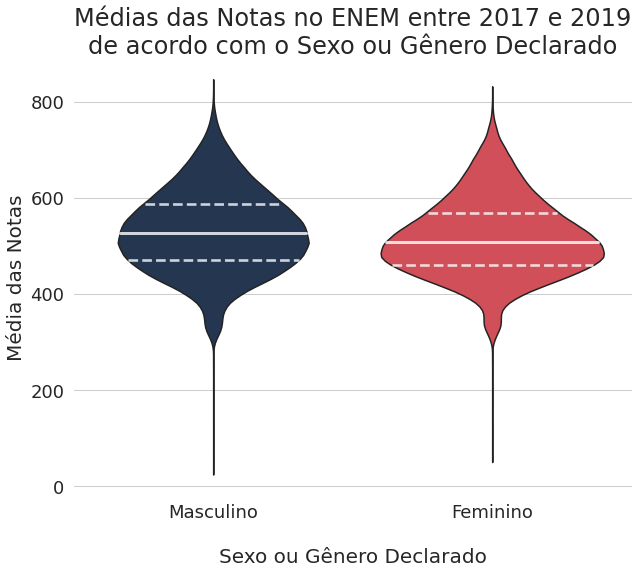

In [ ]:
sns.set(rc={"figure.figsize":(10, 8)})
sns.set_style('whitegrid')

fig = sns.violinplot(
    x=tpsexo_presentes[tpsexo_presentes['NU_NOTA_MEDIA']>=1.0].loc[:,'TP_SEXO'], 
    y=tpsexo_presentes[tpsexo_presentes['NU_NOTA_MEDIA']>=1.0].loc[:,'NU_NOTA_MEDIA'], 
    data=tpsexo_presentes,
    inner='quartile',
    height=8,
    aspect=1.5,
    palette={'Masculino': '#1d3557',  'Feminino': '#e63946'}
)

for l in fig.lines:
    l.set_linestyle('dashed')
    l.set_linewidth(2.6)
    l.set_color('white')
    l.set_alpha(3.8)
for l in fig.lines[1::3]:
    l.set_linestyle('-')
    l.set_linewidth(3.0)
    l.set_color('white')
    l.set_alpha(0.8)

fig.axes.set_title('Médias das Notas no ENEM entre 2017 e 2019\nde acordo com o Sexo ou Gênero Declarado',fontsize=24)
fig.set_xlabel('\nSexo ou Gênero Declarado',fontsize=20)
fig.set_ylabel('Média das Notas',fontsize=20)
fig.tick_params(labelsize=18)
sns.despine(left=True, bottom=True)

In [ ]:
# Salvando figura
fig_name = 'sexo_media_violin'
fig_folder = 'Sexo'
fig_path = f'/content/drive/MyDrive/Colab Notebooks/IC_Data_Science_ENEM/Imagens/{fig_folder}/{fig_name}.png'
fig.figure.savefig(fig_path)

Subplots verticais

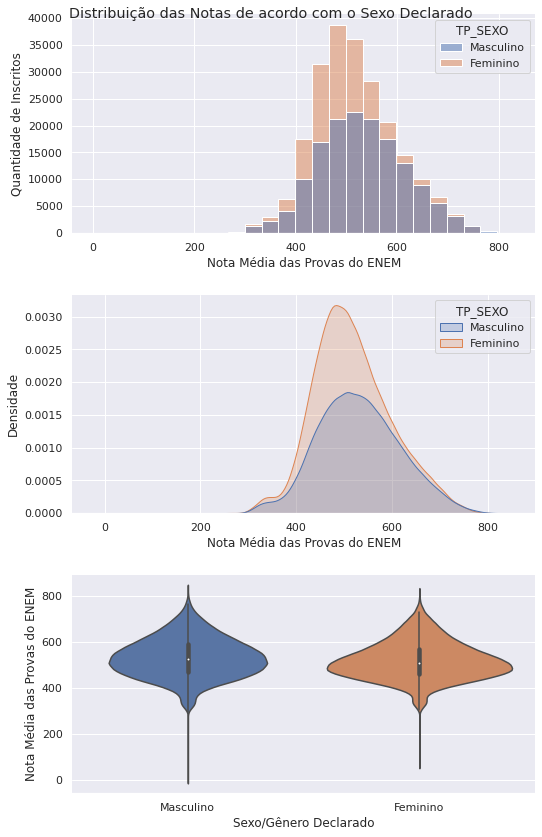

In [ ]:
f, axes = plt.subplots(3, 1, figsize=(8, 12))
sns.despine(left=True, top=True)
f.suptitle('Distribuição das Notas de acordo com o Sexo Declarado')

# Histograma comparando a distribuição de notas entre homens e mulheres
sns.histplot(
    x=tpsexo_presentes['NU_NOTA_MEDIA'],
    hue=tpsexo_presentes['TP_SEXO'],
    bins=25, 
    kde=False,
    ax=axes[0]
)
axes[0].set_title('')
axes[0].set_xlabel('Nota Média das Provas do ENEM')
axes[0].set_ylabel('Quantidade de Inscritos')
#axes[0].legend(['Feminino', 'Masculino'])

# Estimativa de Densidade de Kernel (KDE) entre as notas de homens e mulheres
sns.kdeplot(
    x=tpsexo_presentes['NU_NOTA_MEDIA'], 
    hue=tpsexo_presentes['TP_SEXO'],
    fill=True,
    shade=True,
    ax=axes[1]
)
axes[1].set_title('')
axes[1].set_xlabel('Nota Média das Provas do ENEM')
axes[1].set_ylabel('Densidade')
#axes[1].legend(['Feminino', 'Masculino'])

# Plot "violino"
sns.violinplot(
    y=tpsexo_presentes['NU_NOTA_MEDIA'],
    x=tpsexo_presentes['TP_SEXO'],
    ax=axes[2]
)
axes[2].set_title('')
axes[2].set_xlabel('Sexo/Gênero Declarado')
axes[2].set_ylabel('Nota Média das Provas do ENEM')
#axes[2].set_xticklabels(['Masculino', 'Feminino'])

# Adicionar espaço entre os plots
plt.tight_layout(pad=2)

In [ ]:
# Salvando Figura
fig_name = 'sexo_hist-kde-violin_vertical'
fig_folder = 'Sexo'
fig_path = f'/content/drive/MyDrive/Colab Notebooks/IC_Data_Science_ENEM/Imagens/{fig_folder}/{fig_name}.png'
f.savefig(fig_path)

### Testes Estatísticos

Teste de Simetria

In [ ]:
# Testando a simetria ou distorção da normalidade (skewness)
# CHEATSHEET: Varia entre -1 e 1. Quanto mais próximo de zero, mas simétrica e fiel a uma curva normal.
#             Quanto mais próximo dos extremos, mas assimétrica e distorcidade a amostra.
print('Medida de Distorção Assimétrica em Relação à Média Amostral')
print('\tDistorção na Amostra do Sexo Masculino: {:.4g}'.format(tpsexo_presentes[tpsexo_presentes['TP_SEXO']=='Masculino'].loc[:,'NU_NOTA_MEDIA'].skew()))
print('\tDistorção na Amostra do Sexo Feminino: {:.4g}'.format(tpsexo_presentes[tpsexo_presentes['TP_SEXO']=='Feminino'].loc[:,'NU_NOTA_MEDIA'].skew()))

Medida de Distorção Assimétrica em Relação à Média Amostral
	Distorção na Amostra do Sexo Masculino: 0.1538
	Distorção na Amostra do Sexo Feminino: 0.3596


Média e Desvio Padrão das Amostras

In [ ]:
# Média e Desvio Padrão das Amostras
SEXO_M = tpsexo_presentes[tpsexo_presentes['TP_SEXO']=='Masculino'].loc[:,'NU_NOTA_MEDIA']
SEXO_F = tpsexo_presentes[tpsexo_presentes['TP_SEXO']=='Feminino'].loc[:,'NU_NOTA_MEDIA']

print('Média e Desvio Padrão da Amostra')
print('\nSexo Masculino')
print('\tMédia: {:.4g}\tDesvio Padrão: {:.4g}'.format(SEXO_M.mean(), SEXO_M.std()))
print('\nSexo Feminino')
print('\tMédia: {:.4g}\tDesvio Padrão: {:.4g}'.format(SEXO_F.mean(), SEXO_F.std()))

Média e Desvio Padrão da Amostra

Sexo Masculino
	Média: 530.2	Desvio Padrão: 86

Sexo Feminino
	Média: 517.1	Desvio Padrão: 81.39


Testes de Normalidade

In [ ]:
## Teste de Normalidade (Shapiro, D'Agostino e Anderson-Darling)

# Pelos gráficos, a variável TP_SEXO aparenta
# estar próximo de uma distribuição normal

# H0: a amostra é proveniente de uma distribuição normal
# H1: a amostra não é proveniente de uma distribuição normal
alpha = 0.05  # 5% de significância

# Teste de Shapiro-Wilk
stat, p = shapiro(SEXO_M)
print('\tTeste de Shapiro-Wilk\n')
print('Estatística: {:.3g}'.format(stat))
print("p = {:.3g}".format(p))
if p >= alpha:
  print('Falhou em Rejeitar H0 -> Distribuição Normal\n\n') 
else:
  print('Pode-se Rejeitar H0 -> Distribuição Não-Normal\n\n')

# Teste de D'Agostino
stat, p = normaltest(SEXO_M)
print('\tTeste de D\'Agostino\n')
print('Estatística: {:.3g}'.format(stat))
print("p = {:.3g}".format(p))
if p >= alpha:
  print('Falhou em Rejeitar H0 -> Distribuição Normal\n\n') 
else:
  print('Pode-se Rejeitar H0 -> Distribuição Não-Normal\n\n')

# Teste de Anderson-Darling
print('\tTeste de Anderson-Darling\n')
stat, p, cv = anderson(SEXO_M)
AD = stat*(1 + (.75/50) + 2.25/(50**2))  
print("Adjusted A^2 = ", AD)

if AD >= .6:
  p = math.exp(1.2937 - 5.709*AD - .0186*(AD**2))
elif AD >=.34:
  p = math.exp(.9177 - 4.279*AD - 1.38*(AD**2))
elif AD >.2:
  p = 1 - math.exp(-8.318 + 42.796*AD - 59.938*(AD**2))
else:
  p = 1 - math.exp(-13.436 + 101.14*AD - 223.73*(AD**2))
  
print('p[5%]: {:.3g}'.format(p))
if p >= alpha:
  print('Falhou em Rejeitar H0 -> Distribuição Normal\n\n') 
else:
  print('Pode-se Rejeitar H0 -> Distribuição Não-Normal\n\n')

	Teste de Shapiro-Wilk

Estatística: 0.997
p = 1.08e-41
Pode-se Rejeitar H0 -> Distribuição Não-Normal


	Teste de D'Agostino

Estatística: 708
p = 2.19e-154
Pode-se Rejeitar H0 -> Distribuição Não-Normal


	Teste de Anderson-Darling

Adjusted A^2 =  142.5987186547494
p[5%]: 0
Pode-se Rejeitar H0 -> Distribuição Não-Normal




/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning:

p-value may not be accurate for N > 5000.



Teste de Igualdade das Variâncias

In [ ]:
# Teste de Levene / Brown-Forsythe

# H0: As variâncias das amostras são iguais
# H1: Pelo menos uma variância é diferente

# Center: median. Por conta do valor de assimetria (skewness) das amostras
print('\tTeste de Levene (Brown-Forsythe)\n')
stat, p = levene(SEXO_M, SEXO_F, center='median')

print('Stat: {:.3g}\tp = {:.3g}'.format(stat, p))
if p >= alpha:
  print('Falhou em Rejeitar H0 -> Variâncias Iguais\n\n') 
else:
  print('Pode-se Rejeitar H0 -> Variâncias Diferentes\n\n')

	Teste de Levene (Brown-Forsythe)

Stat: 788	p = 3.72e-173
Pode-se Rejeitar H0 -> Variâncias Diferentes




Teste de Hipótese: Wilcoxon-Mann-Whitney (não-paramétrico)

-   Não se tem informações acerca das distribuições das amostras;
-   Forma (*shape*) similar entre as categorias da variável independente;
-   Amostras independentes;
-   n > 20 amostras.


In [ ]:
## Teste Estatísco (Teste U de Wilcoxon-Mann-Whitney) -> Não-Paramétrico

# Visualmente, não parece haver significância na diferença de variância em TP_SEXO

from scipy.stats import mannwhitneyu

# H0: Os grupos (Masc. e Fem.) possuem médias idênticas de notas
# H1: Os grupos (Masc. e Fem.) possuem médias de notas significantemente distintas

stat, p = mannwhitneyu(
    x = SEXO_M,
    y = SEXO_F
)

print('\tTeste U de Wilcoxon-Mann-Whitney\n')
print('H0: Os grupos (Masc. e Fem.) possuem médias idênticas de notas')
print('H1: Os grupos (Masc. e Fem.) possuem médias de notas significantemente distintas')
print('\nEstatística: {:.5g}'.format(stat))
print("p = {:.5g}".format(p))
if p >= alpha:
  print('Falhou em Rejeitar H0 -> Não Há diferença significativa entre as\nmédias de notas entre os grupos\n\n') 
else:
  print('Pode-se Rejeitar H0 -> Há diferença significativa entre as\nmédias de notas entre os grupos\n\n')

	Teste U de Wilcoxon-Mann-Whitney

H0: Os grupos (Masc. e Fem.) possuem médias idênticas de notas
H1: Os grupos (Masc. e Fem.) possuem médias de notas significantemente distintas

Estatística: 1.4872e+10
p = 0
Pode-se Rejeitar H0 -> Há diferença significativa entre as
médias de notas entre os grupos




In [ ]:
## Teste Estatísco (Teste de Kruskal-Wallis) -> Não-Paramétrico

# Visualmente, não parece haver significância na diferença de variância em TP_SEXO

from scipy.stats import kruskal

# H0: Os grupos (Masc. e Fem.) possuem médias idênticas de notas
# H1: Os grupos (Masc. e Fem.) possuem médias de notas significantemente distintas

stat, p = kruskal(SEXO_M, SEXO_F)

print('\tTeste de Kruskal-Wallis\n')
print('H0: Os grupos (Masc. e Fem.) possuem médias idênticas de notas')
print('H1: Os grupos (Masc. e Fem.) possuem médias de notas significantemente distintas')
print('\nEstatística: {:.5g}'.format(stat))
print("p = {:.5g}".format(p))
if p >= alpha:
  print('Falhou em Rejeitar H0 -> Não Há diferença significativa entre as\nmédias de notas entre os grupos\n\n') 
else:
  print('Pode-se Rejeitar H0 -> Há diferença significativa entre as\nmédias de notas entre os grupos\n\n')

	Teste de Kruskal-Wallis

H0: Os grupos (Masc. e Fem.) possuem médias idênticas de notas
H1: Os grupos (Masc. e Fem.) possuem médias de notas significantemente distintas

Estatística: 2511.1
p = 0
Pode-se Rejeitar H0 -> Há diferença significativa entre as
médias de notas entre os grupos




In [ ]:
# Limpando a variável tpsexo_df e smp_TP_SEXO
#%reset tpsexo_df
#%reset smp_TP_SEXO

## Raça

In [ ]:
# Dicionário de Respostas de TP_COR_RACA
TP_COR_RACA_map = {
    0: 'Não Declarada',
    1: 'Branca',
    2: 'Preta',
    3: 'Parda',
    4: 'Amarela',
    5: 'Indígena'
}

In [ ]:
df_raça_2017 = df[df['NU_ANO']==2017] \
.select('TP_COR_RACA', 'SG_UF_PROVA','NU_NOTA_MEDIA') \
.toPandas()

In [ ]:
df[df['NU_ANO']==2017] \
.groupby('SG_UF_PROVA', 'TP_COR_RACA', 'NU_NOTA_MEDIA') \
.

Infos Gerais

In [ ]:
geral_raça = df.groupby('TP_COR_RACA') \
.count() \
.toPandas()

In [ ]:
geral_raça = geral_raça.sort_values('count', ascending=True).reset_index(drop=True)
geral_raça['Porcentagem'] = geral_raça['count']/np.sum(geral_raça['count'])*100
geral_raça

,TP_COR_RACA,count,Porcentagem
0,5,105663,0.627047
1,0,315363,1.871493
2,4,383198,2.274053
3,2,2177611,12.922831
4,1,6013441,35.686209
5,3,7855606,46.618367


In [ ]:
fig = go.Figure()

fig.add_trace(
    go.Bar(
        name = 'Raça',
        x = geral_raça['count'],
        y = geral_raça['TP_COR_RACA'].map(TP_COR_RACA_map),
        text = geral_raça['Porcentagem'],
        texttemplate = '<b>%{text:.2g}%</b>',
        textposition = 'outside',
        textfont = dict(size=20, color='#013a63'),
        marker = dict(color = '#013a63'),
        orientation = 'h'
    )
)
      
fig.update_layout(
    title = dict(
        text='Distribuição de Inscritos do ENEM entre 2017 e 2019<br>por Cor ou Raça Autodeclarada',
        font=dict(size=24)
    ),
    yaxis = dict(
        title = dict(
            text='Cor ou Raça Autodeclarada',
            font=dict(size=20)
        ),
        tickfont = dict(size=18)
    ),
    xaxis = dict(
        title = dict(
            text='Quantidade de Inscritos',
            font=dict(size=20)
        ),
        range = [0, 8.6e6],
        tickfont = dict(size=18),
    ),
    autosize=True,
    margin=dict(l=1, r=10, t=70, b=5),
    plot_bgcolor='white',
)

fig.show()

In [ ]:
# Salvando Figura
fig_name = 'raça_dist_hbar'
fig_folder = 'Raça'
fig_path = f'/content/drive/MyDrive/Colab Notebooks/IC_Data_Science_ENEM/Imagens/{fig_folder}/{fig_name}.png'
fig.write_image(fig_path)

Amostragem

In [ ]:
# Configurando o tamanho da amostra para 10% do tamanho da população de 2019
# estratificado pela variável TP_COR_RACA
fractions = {cor: 0.1 for cor in TP_COR_RACA_map}

# Coletando amostra estratificada somente no ano de 2019
# para garantir a independência das amostras
smp_TP_COR_RACA = df[df['NU_ANO']=='2019'].sampleBy(col('TP_COR_RACA'), fractions=fractions, seed=0)
smp_TP_COR_RACA.count()

509214

In [ ]:
# Amostragem com a variável de Cor/Raça autodeclarada
tpraca_df = smp_TP_COR_RACA['SG_UF_PROVA', 'TP_COR_RACA', 'TP_PRESENCA', 'NU_NOTA_MEDIA'].toPandas()
tpraca_df['TP_COR_RACA'] = tpraca_df['TP_COR_RACA'].map(TP_COR_RACA_map)
tpraca_df['TP_COR_RACA'].value_counts()

Parda            236362
Branca           182742
Preta             64833
Amarela           11758
Não Declarada     10367
Indígena           3152
Name: TP_COR_RACA, dtype: int64

In [ ]:
tpraca_df = tpraca_df.rename(columns={
    'SG_UF_PROVA': 'Estado',
    'TP_COR_RACA': 'Cor_Raça',
    'NU_NOTA_MEDIA': 'Nota Média'
}).sort_values('Estado', ascending=False) \
.reset_index(drop=True)

In [ ]:
# Pie Chart

pull_vector = [0.02, 0, 0, 0, 0, 0]
labels = tpraca_df['Cor_Raça'].unique().tolist()
values = [tpraca_df['Cor_Raça'].loc[tpraca_df['Cor_Raça']==label].count() for label in labels]

data=[
      go.Pie(
          labels=labels, 
          values=values, 
          pull=pull_vector,
          hole=.3,
          textinfo='label+percent',
          texttemplate='<b>%{label}<br>%{percent}</b>',
          textfont={'size':20},
          insidetextfont={'color': 'white'},
          outsidetextfont={'color': 'black'},
          marker_colors=['rgb(29, 53, 87, 1)', 'rgb(230, 57, 70, 1)',
                         'rgb(255, 131, 0, 1)', 'rgb(152, 82, 119, 1)',
                         'rgb(25, 114, 120, 1)', 'rgb(29, 132, 181, 1)']
      )
]

fig = go.Figure(data=data)

fig.update_layout(
    title = dict(
        text='Distribuição de Cor ou Raça Declarada pelos Inscritos do ENEM',
        font=dict(size=22)
    ),
    legend = dict(
        font=dict(size=16),
        title=dict(
            text='Cor ou Raça<br>Autodeclarada<br>',
            font=dict(size=18)
        )
    ),
    annotations=[dict(text='Cor ou<br>Raça', x=0.5, y=0.5, font_size=20, showarrow=False)], # Update Legenda
    autosize=True,
    margin={'l':1, 'r':1, 't':35, 'b':1}
)

fig.show()

In [ ]:
# Salvando Figura
fig_name = 'raça_donut'
fig_folder = 'Raça'
fig_path = f'/content/drive/MyDrive/Colab Notebooks/IC_Data_Science_ENEM/Imagens/{fig_folder}/{fig_name}.png'
fig.write_image(fig_path)

Índices de Desistência por Cor ou Raça Autodeclarada

In [ ]:
tpraca_df['TP_PRESENCA'] = tpraca_df['TP_PRESENCA'].map({0: 'Ausente', 1: 'Presente'})

In [ ]:
tpraca_df.head()

,Estado,Cor_Raça,TP_PRESENCA,Nota Média
0,TO,Parda,Presente,479.70
1,TO,Branca,Presente,474.88
2,TO,Parda,Presente,399.14
3,TO,Não Declarada,Presente,540.96
4,TO,Branca,Presente,578.24


In [ ]:
raças = tpraca_df['Cor_Raça'].unique().tolist()

desistencia = list()
for raça in raças:
  des_temp = tpraca_df[tpraca_df['Cor_Raça']==raça].loc[:,'TP_PRESENCA'].value_counts().tolist()
  desistencia.append(np.round(des_temp[1]/(des_temp[1]+des_temp[0])*100, 2))

In [ ]:
tpraça_desistencia = pd.DataFrame(np.array([raças, desistencia]).T, columns=['Raça', 'Desistencia'])

In [ ]:
fig = go.Figure()

labels = ['Não Declarada','Branca','Amarela','Parda','Preta','Indígena']
values = [tpraça_desistencia['Desistencia'].loc[tpraça_desistencia['Raça']==label].astype(float).values.tolist()[0] for label in labels]

fig.add_trace(
    go.Bar(
        name = 'Cor_Raça',
        x = values,
        y = labels,
        text = values,
        texttemplate = '<b>%{text:.1f}%</b>',
        textposition = 'outside',
        textfont = dict(size=20, color='#013a63'),
        marker = dict(color = '#013a63'),
        orientation = 'h'
    )
)
      
fig.update_layout(
    title = dict(
        text='Nível de Desistência do ENEM de acordo<br>com cada Cor ou Raça Autodeclarada',
        font=dict(size=24)
    ),
    yaxis = dict(
        title = dict(
            text='Cor ou Raça Autodeclarada',
            font=dict(size=20)
        ),
        tickfont = dict(size=18)
    ),
    xaxis = dict(
        title = dict(
            text='Índice de Desistência',
            font=dict(size=20)
        ),
        tickfont = dict(size=18),
        range=[23,33.9]
    ),
    autosize=True,
    margin=dict(l=1, r=10, t=70, b=5),
    plot_bgcolor='white',
)

fig.show()

In [ ]:
# Salvando Figura
fig_name = 'raça_desistencia_hbar'
fig_folder = 'Raça'
fig_path = f'/content/drive/MyDrive/Colab Notebooks/IC_Data_Science_ENEM/Imagens/{fig_folder}/{fig_name}.png'
fig.write_image(fig_path)

Notas Médias

In [ ]:
raças = tpraca_df['Cor_Raça'].unique().tolist()
notas = [tpraca_df[tpraca_df['Cor_Raça']==raça].loc[:,'Nota Média'].mean() for raça in raças]

In [ ]:
tpraça_media = pd.DataFrame(np.array([raças, notas]).T, columns=['Raça', 'Notas Médias'])

In [ ]:
tpraça_media

,Raça,Notas Médias
0,Parda,507.19488451728057
1,Branca,548.1741816322757
2,Não Declarada,528.706808394658
3,Amarela,520.9612459321238
4,Preta,502.58918460045993
5,Indígena,479.43585331452766


In [ ]:
fig = go.Figure()

labels = ['Branca','Amarela','Parda','Preta','Indígena', 'Não Declarada']
values = [tpraça_media['Notas Médias'].loc[tpraça_media['Raça']==label].astype(float).values.tolist()[0] for label in labels]

fig.add_trace(
    go.Bar(
        name = 'Cor_Raça',
        x = labels,
        y = values,
        text = values,
        texttemplate = '<b>%{text:.1f}</b>',
        textposition = 'outside',
        textfont = dict(size=20, color='#013a63'),
        marker = dict(color = '#013a63'),
    )
)
      
fig.update_layout(
    title = dict(
        text='Nota Média do ENEM de acordo<br>com cada Cor ou Raça Autodeclarada',
        font=dict(size=24)
    ),
    yaxis = dict(
        title = dict(
            text='Média de Notas nas Provas',
            font=dict(size=20)
        ),
        tickvals = [480, 500, 520, 540],
        tickfont = dict(size=18),
        range=[465,555]
    ),
    xaxis = dict(
        title = dict(
            text='Cor ou Raça Autodeclarada',
            font=dict(size=20)
        ),
        tickfont = dict(size=18),
    ),
    autosize=True,
    margin=dict(l=1, r=10, t=70, b=5),
    plot_bgcolor='white',
)

fig.show()

In [ ]:
# Salvando Figura
fig_name = 'raça_media_bar'
fig_folder = 'Raça'
fig_path = f'/content/drive/MyDrive/Colab Notebooks/IC_Data_Science_ENEM/Imagens/{fig_folder}/{fig_name}.png'
fig.write_image(fig_path)

Subplots

In [ ]:
# Pie plots
fig = make_subplots(
    rows=3, cols=2,
    specs=[[{'type':'domain'}, {'type':'domain'}],
           [{'type':'domain'}, {'type':'domain'}],
           [{'type':'domain'}, {'type':'domain'}]])

labels = tpraca_df['TP_PRESENCA'].unique().tolist()

fig.add_trace(
    go.Pie(
        labels = labels, 
        values = tpraca_df['TP_PRESENCA'].loc[tpraca_df['Cor_Raça']=='Indígena'].value_counts().tolist(),
        hole=.3,
        pull=[0.0, 0.05],
        textinfo='label+percent',
        texttemplate='<b>%{label}<br>%{percent}</b>',
        outsidetextfont={'size':18, 'color': 'rgb(29, 132, 181, 1)'},
        marker_colors=['rgb(222, 226, 255, 1)', 'rgb(29, 132, 181, 1)'],
        title='Indígena<br>\n',
        titleposition='top center',
        titlefont={'size':20},        
    ), 1, 1
)
fig.add_trace(
    go.Pie(
        labels = labels, 
        values = tpraca_df['TP_PRESENCA'].loc[tpraca_df['Cor_Raça']=='Preta'].value_counts().tolist(),
        hole=.3,
        pull=[0.0, 0.05],
        textinfo='label+percent',
        texttemplate='<b>%{label}<br>%{percent}</b>',
        outsidetextfont={'size':18, 'color': 'rgb(25, 114, 120, 1)'},
        marker_colors=['rgb(216, 226, 220, 1)', 'rgb(25, 114, 120, 1)'],
        title='Preta<br>\n',
        titleposition='top center',
        titlefont={'size':20},        
    ), 1, 2
)
fig.add_trace(
    go.Pie(
        labels = labels, 
        values = tpraca_df['TP_PRESENCA'].loc[tpraca_df['Cor_Raça']=='Parda'].value_counts().tolist(),
        hole=.3,
        pull=[0.0, 0.05],
        textinfo='label+percent',
        texttemplate='<b>%{label}<br>%{percent}</b>',
        outsidetextfont={'size':18, 'color': 'rgb(29, 53, 87, 1)'},
        marker_colors=['rgb(174, 217, 224, 1)', 'rgb(29, 53, 87, 1)'],
        title='Parda<br>\n',
        titleposition='top center',
        titlefont={'size':20},        
    ), 2, 1
)
fig.add_trace(
    go.Pie(
        labels = labels, 
        values = tpraca_df['TP_PRESENCA'].loc[tpraca_df['Cor_Raça']=='Amarela'].value_counts().tolist(),
        hole=.3,
        pull=[0.0, 0.05],
        textinfo='label+percent',
        texttemplate='<b>%{label}<br>%{percent}</b>',
        outsidetextfont={'size':18, 'color': 'rgb(152, 82, 119, 1)'},
        marker_colors=['rgb(203, 192, 211, 1)', 'rgb(152, 82, 119, 1)'],
        title='Amarela<br>\n',
        titleposition='top center',
        titlefont={'size':20},        
    ), 2, 2
)
fig.add_trace(
    go.Pie(
        labels = labels, 
        values = tpraca_df['TP_PRESENCA'].loc[tpraca_df['Cor_Raça']=='Branca'].value_counts().tolist(),
        hole=.3,
        pull=[0.0, 0.05],
        textinfo='label+percent',
        texttemplate='<b>%{label}<br>%{percent}</b>',
        outsidetextfont={'size':18, 'color': 'rgb(230, 57, 70, 1)'},
        marker_colors=['rgb(252, 213, 206, 1)', 'rgb(230, 57, 70, 1)'],
        title='Branca<br>\n',
        titleposition='top center',
        titlefont={'size':20},        
    ), 3, 1
)
fig.add_trace(
    go.Pie(
        labels = labels, 
        values = tpraca_df['TP_PRESENCA'].loc[tpraca_df['Cor_Raça']=='Não Declarada'].value_counts().tolist(),
        hole=.3,
        pull=[0.0, 0.05],
        textinfo='label+percent',
        texttemplate='<b>%{label}<br>%{percent}</b>',
        outsidetextfont={'size':18, 'color': 'rgb(255, 131, 0, 1)'},
        marker_colors=['rgb(254, 200, 154, 1)', 'rgb(255, 131, 0, 1)'],
        title='Não Declarada<br>\n',
        titleposition='top center',
        titlefont={'size':20},        
    ), 3, 2
)

fig.update_layout(
    title = dict(
        text='Desistência por Cor ou Raça dos Inscritos do ENEM',
        font=dict(size=24)
    ),
    showlegend=False,
    autosize=False,    
    width=700,
    height=600,
    margin={'l':1, 'b':1, 't':35, 'r':1}
)

fig.show()

In [ ]:
# Salvando Figura
fig_name = 'raça_desistencia_donuts'
fig_folder = 'Raça'
fig_path = f'/content/drive/MyDrive/Colab Notebooks/IC_Data_Science_ENEM/Imagens/{fig_folder}/{fig_name}.png'
fig.write_image(fig_path)

### Visualização Estatística

In [ ]:
tpraca_presentes = tpraca_df.loc[tpraca_df['TP_PRESENCA']=='Presente']

In [ ]:
tpraca_presentes.head()

,Estado,Cor_Raça,TP_PRESENCA,Nota Média
0,TO,Parda,Presente,479.70
1,TO,Branca,Presente,474.88
2,TO,Parda,Presente,399.14
3,TO,Não Declarada,Presente,540.96
4,TO,Branca,Presente,578.24


In [ ]:
tpraca_presentes[tpraca_presentes['Nota Média']==0.0].count()

Estado         1
Cor_Raça       1
TP_PRESENCA    1
Nota Média     1
dtype: int64

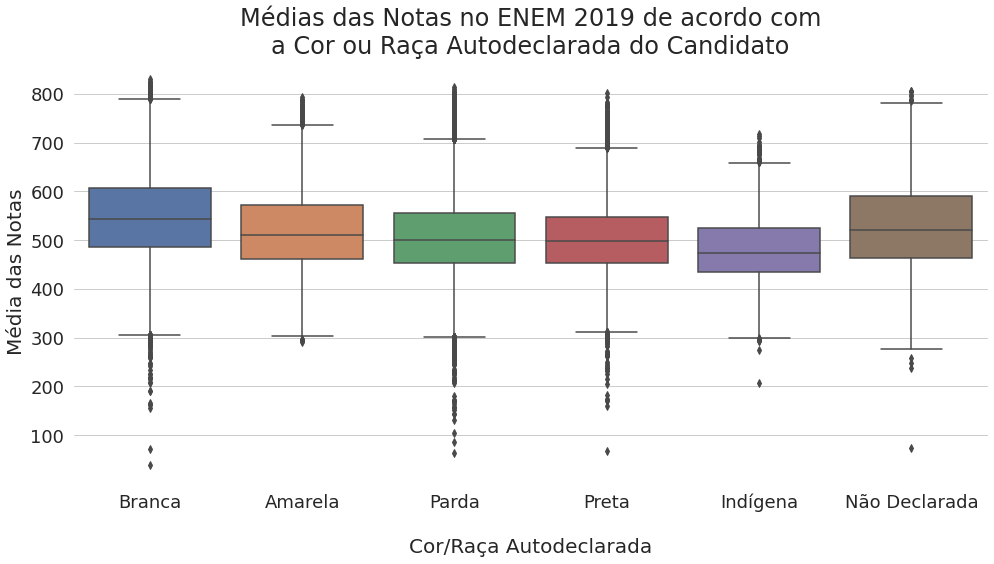

In [ ]:
sns.set(rc={"figure.figsize":(14, 8)})
sns.set_style('whitegrid')
labels = ['Branca','Amarela','Parda','Preta','Indígena', 'Não Declarada']

fig = sns.boxplot(
    x=tpraca_presentes[tpraca_presentes['Nota Média']>0.0].loc[:,'Cor_Raça'],
    y=tpraca_presentes[tpraca_presentes['Nota Média']>0.0].loc[:,'Nota Média'],
    data=tpraca_presentes,
    order=labels
)

fig.axes.set_title('Médias das Notas no ENEM 2019 de acordo com\na Cor ou Raça Autodeclarada do Candidato',fontsize=24)
fig.set_xlabel('\nCor/Raça Autodeclarada',fontsize=20)
fig.set_ylabel('Média das Notas',fontsize=20)
fig.tick_params(labelsize=18)
sns.despine(left=True, bottom=True)
plt.tight_layout()

In [ ]:
# Salvando Figura
fig_name = 'raça_media_box'
fig_folder = 'Raça'
fig_path = f'/content/drive/MyDrive/Colab Notebooks/IC_Data_Science_ENEM/Imagens/{fig_folder}/{fig_name}.png'
fig.figure.savefig(fig_path)

Subplots

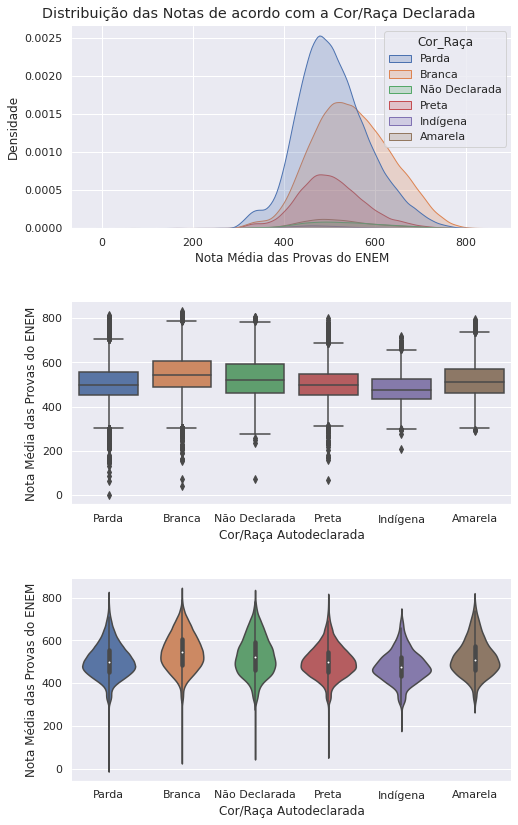

In [ ]:
f, axes = plt.subplots(3, 1, figsize=(8, 12))
sns.despine(left=True, top=True)
f.suptitle('Distribuição das Notas de acordo com a Cor/Raça Declarada')

# Estimativa de Densidade de Kernel (KDE) entre as notas de homens e mulheres
sns.kdeplot(
    x=tpraca_presentes['Nota Média'], 
    hue=tpraca_presentes['Cor_Raça'],
    fill=True,
    shade=True,
    ax=axes[0]
)
axes[0].set_title('')
axes[0].set_xlabel('Nota Média das Provas do ENEM')
axes[0].set_ylabel('Densidade')

# Boxplot comparando a distribuição de notas entre as raças disponíveis
sns.boxplot(
    y=tpraca_presentes['Nota Média'],
    x=tpraca_presentes['Cor_Raça'],
    ax=axes[1]
)
axes[1].set_title('')
axes[1].set_xlabel('Cor/Raça Autodeclarada')
axes[1].set_ylabel('Nota Média das Provas do ENEM')

# Plot "violino"
sns.violinplot(
    y=tpraca_presentes['Nota Média'],
    x=tpraca_presentes['Cor_Raça'],
    ax=axes[2]
)
axes[2].set_title('')
axes[2].set_xlabel('Cor/Raça Autodeclarada')
axes[2].set_ylabel('Nota Média das Provas do ENEM')

# Adicionar espaço entre os plots
plt.tight_layout(pad=3)

In [ ]:
# Salvando Figura
fig_name = 'raça_kde-box-violin'
fig_folder = 'Raça'
fig_path = f'/content/drive/MyDrive/Colab Notebooks/IC_Data_Science_ENEM/Imagens/{fig_folder}/{fig_name}.png'
f.savefig(fig_path)

### Testes Estatísticos

In [ ]:
## TESTE ESTATÍSTICO
# Por meio dos gráficos, não se observa diferença
# significante entre as médias das categorias

Teste de Simetria

In [ ]:
# Testando a simetria ou distorção da normalidade (skewness)
# CHEATSHEET: Varia entre -1 e 1. Quanto mais próximo de zero, mas simétrica e fiel a uma curva normal.
#             Quanto mais próximo dos extremos, mas assimétrica e distorcidade a amostra.
print('Medida de Distorção Assimétrica em Relação à Média Amostral das Categorias')
for raça in tpraca_presentes['Cor_Raça'].unique().tolist():
  print('\tRaça {}: {:.4g}'.format(raça, tpraca_presentes[tpraca_presentes['Cor_Raça']==raça].loc[:,'Nota Média'].skew()))

Medida de Distorção Assimétrica em Relação à Média Amostral das Categorias
	Raça Parda: 0.3256
	Raça Branca: 0.1091
	Raça Não Declarada: 0.1789
	Raça Preta: 0.2485
	Raça Indígena: 0.2613
	Raça Amarela: 0.4353


Média e Desvio Padrão das Amostras

In [ ]:
# Média e Desvio Padrão das Amostras
print('Média e Desvio Padrão da Amostra\n')
for raça in tpraca_presentes['Cor_Raça'].unique().tolist():
  categoria_raça = tpraca_presentes[tpraca_presentes['Cor_Raça']==raça].loc[:,'Nota Média']
  print('\nRaça {}'.format(raça))
  print('\tMédia: {:.4g}\tDesvio Padrão: {:.4g}'.format(categoria_raça.mean(), categoria_raça.std()))

Média e Desvio Padrão da Amostra


Raça Parda
	Média: 507.2	Desvio Padrão: 78.52

Raça Branca
	Média: 548.2	Desvio Padrão: 85.61

Raça Não Declarada
	Média: 528.7	Desvio Padrão: 91.59

Raça Preta
	Média: 502.6	Desvio Padrão: 73.77

Raça Indígena
	Média: 479.4	Desvio Padrão: 72.92

Raça Amarela
	Média: 521	Desvio Padrão: 84.02


Testes de Normalidade

In [ ]:
## Teste de Normalidade (Shapiro, D'Agostino e Anderson-Darling)

# Pelos gráficos, a variável TP_SEXO aparenta
# estar próximo de uma distribuição normal

# H0: a amostra é proveniente de uma distribuição normal
# H1: a amostra não é proveniente de uma distribuição normal
alpha = 0.05  # 5% de significância

# Teste de Shapiro-Wilk
print('\tTeste de Shapiro-Wilk\n')

for raça in tpraca_presentes['Cor_Raça'].unique().tolist():
  categoria_raça = tpraca_presentes[tpraca_presentes['Cor_Raça']==raça].loc[:,'Nota Média']
  stat, p = shapiro(categoria_raça)

  print(f'\nCategoria: {raça}')
  print('Stat: {:.3g}\tp: {:.3g}'.format(stat, p))
  if p >= alpha:
    print('Falhou em Rejeitar H0 -> Distribuição Normal\n\n') 
  else:
    print('Pode-se Rejeitar H0 -> Distribuição Não-Normal\n\n')

# Teste de D'Agostino
print('\tTeste de D\'Agostino\n')

for raça in tpraca_presentes['Cor_Raça'].unique().tolist():
  categoria_raça = tpraca_presentes[tpraca_presentes['Cor_Raça']==raça].loc[:,'Nota Média']
  stat, p = normaltest(categoria_raça)

  print(f'\nCategoria: {raça}')
  print('Stat: {:.3g}\tp: {:.3g}'.format(stat, p))
  if p >= alpha:
    print('Falhou em Rejeitar H0 -> Distribuição Normal\n\n') 
  else:
    print('Pode-se Rejeitar H0 -> Distribuição Não-Normal\n\n')

# Teste de Anderson-Darling
print('\tTeste de Anderson-Darling\n')

for raça in tpraca_presentes['Cor_Raça'].unique().tolist():
  categoria_raça = tpraca_presentes[tpraca_presentes['Cor_Raça']==raça].loc[:,'Nota Média']
  stat, p, cv = anderson(categoria_raça)

  print(f'\nCategoria: {raça}')
  AD = stat*(1 + (.75/50) + 2.25/(50**2))  
  print("Adjusted A^2 = ", AD)

  if AD >= .6:
      p = math.exp(1.2937 - 5.709*AD - .0186*(AD**2))
  elif AD >=.34:
      p = math.exp(.9177 - 4.279*AD - 1.38*(AD**2))
  elif AD >.2:
      p = 1 - math.exp(-8.318 + 42.796*AD - 59.938*(AD**2))
  else:
      p = 1 - math.exp(-13.436 + 101.14*AD - 223.73*(AD**2))
  
  print('p[5%]: {:.3g}'.format(p))
  if p >= alpha:
    print('Falhou em Rejeitar H0 -> Distribuição Normal\n\n') 
  else:
    print('Pode-se Rejeitar H0 -> Distribuição Não-Normal\n\n')

	Teste de Shapiro-Wilk


Categoria: Parda
Stat: 0.992	p: 0
Pode-se Rejeitar H0 -> Distribuição Não-Normal



Categoria: Branca
Stat: 0.997	p: 6.68e-43
Pode-se Rejeitar H0 -> Distribuição Não-Normal



Categoria: Não Declarada
Stat: 0.994	p: 1.48e-16
Pode-se Rejeitar H0 -> Distribuição Não-Normal



Categoria: Preta
Stat: 0.994	p: 1.3e-37
Pode-se Rejeitar H0 -> Distribuição Não-Normal



Categoria: Indígena
Stat: 0.992	p: 2.17e-09
Pode-se Rejeitar H0 -> Distribuição Não-Normal



Categoria: Amarela
Stat: 0.985	p: 2.01e-29
Pode-se Rejeitar H0 -> Distribuição Não-Normal


	Teste de D'Agostino



/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning:

p-value may not be accurate for N > 5000.




Categoria: Parda
Stat: 3.11e+03	p: 0
Pode-se Rejeitar H0 -> Distribuição Não-Normal



Categoria: Branca
Stat: 879	p: 1.59e-191
Pode-se Rejeitar H0 -> Distribuição Não-Normal



Categoria: Não Declarada
Stat: 66.7	p: 3.32e-15
Pode-se Rejeitar H0 -> Distribuição Não-Normal



Categoria: Preta
Stat: 624	p: 4.03e-136
Pode-se Rejeitar H0 -> Distribuição Não-Normal



Categoria: Indígena
Stat: 32	p: 1.15e-07
Pode-se Rejeitar H0 -> Distribuição Não-Normal



Categoria: Amarela
Stat: 250	p: 5.71e-55
Pode-se Rejeitar H0 -> Distribuição Não-Normal


	Teste de Anderson-Darling


Categoria: Parda
Adjusted A^2 =  488.42864434342187
p[5%]: 0
Pode-se Rejeitar H0 -> Distribuição Não-Normal



Categoria: Branca
Adjusted A^2 =  154.12985864514275
p[5%]: 0
Pode-se Rejeitar H0 -> Distribuição Não-Normal



Categoria: Não Declarada
Adjusted A^2 =  14.039866735950469
p[5%]: 1.44e-36
Pode-se Rejeitar H0 -> Distribuição Não-Normal



Categoria: Preta
Adjusted A^2 =  82.80264441196466
p[5%]: 7.55e-261
Pode-s

Teste de Igualdade das Variâncias

In [ ]:
# Teste de Levene / Brown-Forsythe

# H0: As variâncias das amostras são iguais
# H1: Pelo menos uma variância é diferente

# Center: median. Por conta do valor de assimetria (skewness) das amostras
print('\tTeste de Levene (Brown-Forsythe)\n')

categorias_raça = list()
for raça in tpraca_presentes['Cor_Raça'].unique().tolist():
  categorias_raça.append(tpraca_presentes[tpraca_presentes['Cor_Raça']==raça].loc[:,'Nota Média'])

stat, p = levene(*categorias_raça, center='median')

print('Stat: {:.3g}\tp = {:.3g}'.format(stat, p))
if p >= alpha:
  print('Falhou em Rejeitar H0 -> Variâncias Iguais\n\n') 
else:
  print('Pode-se Rejeitar H0 -> Variâncias Diferentes\n\n')

	Teste de Levene (Brown-Forsythe)

Stat: 616	p = 0
Pode-se Rejeitar H0 -> Variâncias Diferentes




Teste de Hipótese: Kruskal-Wallis (não-paramétrico)

-   Não se tem informações acerca das distribuições das amostras;
-   Forma (*shape*) similar entre as categorias da variável independente;
-   Amostras independentes;
-   n > 20 amostras;
-   Não atende aos requisitos de normalidade e igualdade de variância para ANOVA.


In [ ]:
## Teste Estatísco (Teste de Kruskal-Wallis) -> Não-Paramétrico

# Visualmente, parece haver significância na diferença de variância em TP_COR_RACA

# H0: Os grupos possuem medianas idênticas de notas
# H1: Os grupos possuem medianas de notas significantemente distintas

raça_group = [tpraca_presentes[tpraca_presentes['Cor_Raça']==raça].loc[:,'Nota Média'] for raça in tpraca_presentes['Cor_Raça'].unique().tolist()]
stat, p = kruskal(*raça_group)

print('\tTeste de Kruskal-Wallis\n')
print('H0: Os grupos possuem medianas idênticas de notas')
print('H1: Os grupos possuem medianas de notas significantemente distintas')
print('\nEstatística: {:.5g}'.format(stat))
print("p = {:.5g}".format(p))
if p >= alpha:
  print('Falhou em Rejeitar H0 -> Não Há diferença significativa entre as\nmédias de notas entre os grupos\n\n') 
else:
  print('Pode-se Rejeitar H0 -> Há diferença significativa entre as\nmédias de notas entre os grupos\n\n')

	Teste de Kruskal-Wallis

H0: Os grupos possuem medianas idênticas de notas
H1: Os grupos possuem medianas de notas significantemente distintas

Estatística: 21290
p = 0
Pode-se Rejeitar H0 -> Há diferença significativa entre as
médias de notas entre os grupos




In [ ]:
# Teste de Nemeyi ou Connover

In [ ]:
## Limpando a variável tpraca_df
#%reset tpraca_df

## Conclusão do Ensino Médio

In [ ]:
# Dicionário para a variável TP_ANO_CONCLUIU
TP_ANO_CONCLUIU_map = {
    0: 'Em curso',
    1: '1 ano',
    2: '2 anos',
    3: '3 anos',
    4: '4 anos',
    5: '5 anos',
    6: '6 anos',
    7: '7 anos',
    8: '8 anos',
    9: '9 anos',
    10: '10+ anos'
}

Visualização geral do tempo de conclusão do Ensino Médio

In [ ]:
geral_concluiu = df.groupBy('TP_ANO_CONCLUIU') \
.count() \
.orderBy('TP_ANO_CONCLUIU', ascending=False) \
.toPandas()

In [ ]:
geral_concluiu['Porcentagem'] = geral_concluiu['count']/np.sum(geral_concluiu['count'])*100
geral_concluiu

,TP_ANO_CONCLUIU,count,Porcentagem
0,10,2105225,12.493263
1,9,319131,1.893853
2,8,375271,2.227011
3,7,445283,2.642491
4,6,517343,3.070124
5,5,652531,3.872385
6,4,818319,4.856238
7,3,1071319,6.357643
8,2,1481873,8.794038
9,1,2181141,12.943779


In [ ]:
fig = go.Figure()

fig.add_trace(
    go.Bar(
        y=geral_concluiu['TP_ANO_CONCLUIU'].map(TP_ANO_CONCLUIU_map),  
        x=geral_concluiu['Porcentagem'],      
        name='Inscritos',
        orientation='h',
        text=geral_concluiu['Porcentagem'],
        textposition='outside',
        textfont=dict(size=18, color='#013a63'),
        texttemplate='<b>%{text:.2g}%</b>',
        marker=dict(color='#013a63')
    )
)

fig.update_layout(
    title=dict(
        text='Inscritos por Tempo de Conclusão do Ensino Médio',
        font=dict(size=24)
    ),
    xaxis=dict(
        title=dict(
            text='Quantidade de Inscritos [%]',
            font=dict(size=20)
        ),
        range=[0, 45],
        showticklabels=False
    ),
    yaxis=dict(
        title=dict(
            text='Tempo de Conclusão do Ensino Médio',
            font=dict(size=20)
        ),
        tickfont=dict(size=18)
    ),
    autosize=True,
    margin=dict(l=1, r=10, t=35, b=1),
    plot_bgcolor='white'
)

fig.show()

In [ ]:
# Salvando Figura
fig_name = 'conclusao_inscritos_hbar'
fig_folder = 'Conclusao'
fig_path = f'/content/drive/MyDrive/Colab Notebooks/IC_Data_Science_ENEM/Imagens/{fig_folder}/{fig_name}.png'
fig.write_image(fig_path)

Amostragem

In [ ]:
# Configurando o tamanho da amostra para 10% do tamanho da população de 2019
# estratificado pela variável TP_COR_RACA
fractions = {cor: 0.1 for cor in TP_ANO_CONCLUIU_map}

# Coletando amostra estratificada somente no ano de 2019
# para garantir a independência das amostras
smp_TP_CONCLUSAO = df[df['NU_ANO']=='2019'].sampleBy(col('TP_ANO_CONCLUIU'), fractions=fractions, seed=0)
smp_TP_CONCLUSAO.count()

509214

In [ ]:
# Amostragem com a variável de Cor/Raça autodeclarada
tpconcluiu_df = smp_TP_CONCLUSAO['SG_UF_PROVA', 'TP_ANO_CONCLUIU', 'NU_IDADE', 'TP_PRESENCA', 'NU_NOTA_MEDIA'].toPandas()
#tpconcluiu_df['TP_COR_RACA'] = tpraca_df['TP_COR_RACA'].map(TP_COR_RACA_map)
tpconcluiu_df['TP_ANO_CONCLUIU'].value_counts()

0     219836
1      65883
10     60754
2      44683
3      30781
4      23412
5      18397
6      14521
7      12423
8       9785
9       8739
Name: TP_ANO_CONCLUIU, dtype: int64

Barras Horizontais

In [ ]:
fig = go.Figure()

labels = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]
values = [tpconcluiu_df['TP_ANO_CONCLUIU'].loc[tpconcluiu_df['TP_ANO_CONCLUIU']==label].count() for label in labels]
percent = [np.round(count/np.sum(values)*100, 2) for count in values]

fig.add_trace(
    go.Bar(
        y=pd.Series(labels).map(TP_ANO_CONCLUIU_map),  
        x=percent,      
        name='Inscritos',
        orientation='h',
        text=percent,
        textposition='outside',
        textfont=dict(size=18, color='#013a63'),
        texttemplate='<b>%{text}%</b>',
        marker=dict(color='#013a63')
    )
)

fig.update_layout(
    title=dict(
        text='Inscritos por Tempo de Conclusão do Ensino Médio',
        font=dict(size=24)
    ),
    xaxis=dict(
        title=dict(
            text='Quantidade de Inscritos [%]',
            font=dict(size=20)
        ),
        range=[0, 50],
        showticklabels=False
    ),
    yaxis=dict(
        title=dict(
            text='Tempo de Conclusão do Ensino Médio',
            font=dict(size=20)
        ),
        tickfont=dict(size=18)
    ),
    autosize=True,
    margin=dict(l=1, r=10, t=35, b=1),
    plot_bgcolor='white'
)

fig.show()

In [ ]:
# Salvando Figura
fig_name = 'conclusao_inscritos_hbar'
fig_folder = 'Conclusao'
fig_path = f'/content/drive/MyDrive/Colab Notebooks/IC_Data_Science_ENEM/Imagens/{fig_folder}/{fig_name}.png'
fig.write_image(fig_path)

Razão de Desistências ao longo do Tempo de Conclusão do Ensino Médio

In [ ]:
# Separando os presentes e os ausentes
tpconcluiu_presentes = tpconcluiu_df.loc[tpconcluiu_df['TP_PRESENCA']==1]
tpconcluiu_ausentes = tpconcluiu_df.loc[tpconcluiu_df['TP_PRESENCA']==0]

In [ ]:
# Montando o DataFrame com a porcentagem de desistentes para cada tempo de concllusão
conclusao_desistencia = pd.DataFrame(data=np.array([
    tpconcluiu_presentes.groupby('TP_ANO_CONCLUIU')['TP_ANO_CONCLUIU'].count(),
    tpconcluiu_ausentes.groupby('TP_ANO_CONCLUIU')['TP_ANO_CONCLUIU'].count()]).T
)
conclusao_desistencia['Desistência'] = conclusao_desistencia[1]/(conclusao_desistencia[1]+conclusao_desistencia[0])*100
conclusao_desistencia['Desistência'] = np.round(conclusao_desistencia['Desistência'], 2)
conclusao_desistencia = conclusao_desistencia.rename(columns={0: 'Presentes', 1: 'Ausentes'})
conclusao_desistencia.head()

,Presentes,Ausentes,Desistência
0,181466,38370,17.45
1,48741,17142,26.02
2,31187,13496,30.20
3,20743,10038,32.61
4,15004,8408,35.91


In [ ]:
# Criando interpolação

x = conclusao_desistencia.index
y = conclusao_desistencia['Desistência']
z = np.polyfit(x, y, 2)
f = np.poly1d(z)

In [ ]:
# Configurações dos dados a serem plotados
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        name = 'Interpolação',
        x = conclusao_desistencia.index.map(TP_ANO_CONCLUIU_map),
        y = f(conclusao_desistencia.index),
        line = dict(
            color='rgb(230, 57, 70, 1)',
            shape='spline',
            dash='dash',
            width=1.5,
        ),
    )
)
fig.add_trace(
    go.Scatter(
        name = 'Desistência',
        x = conclusao_desistencia.index.map(TP_ANO_CONCLUIU_map),
        y = conclusao_desistencia['Desistência'],        
        mode='markers+text',
        text = conclusao_desistencia['Desistência'],
        texttemplate='<b>%{text:.2s}%</b>', 
        textposition='top center', 
        textfont={'size': 20, 'color':'#013a63'},
        marker=dict(
            symbol='x',
            size=15,
            color='#013a63'
        )
    ),
)

fig.update_layout(
    title = dict(
        text='Desistência por Tempo de Conclusão do Ensino Médio',
        font=dict(size=24)
    ),
    yaxis = dict(
        title = dict(
            text='Proporção de Desistência',
            font=dict(size=20)
        ),
        tickfont = dict(size=18),
        ticksuffix = '%',
        range = [15, 47],
        linecolor = '#BCCCDC',
    ),
    xaxis = dict(
        title = dict(
            text='Tempo de Conclusão do Ensino Médio',
            font=dict(size=20)
        ),
        tickfont = dict(size=18),
        linecolor = '#BCCCDC'
    ),
    showlegend=False,
    autosize = True,
    margin = {'l':1, 'r':1, 't':35, 'b':1},
    plot_bgcolor = 'white'
)

fig.show()

In [ ]:
# Salvando Figura
fig_name = 'conclusao_desistencia_scatter'
fig_folder = 'Conclusao'
fig_path = f'/content/drive/MyDrive/Colab Notebooks/IC_Data_Science_ENEM/Imagens/{fig_folder}/{fig_name}.png'
fig.write_image(fig_path)

### Visualização Estatística

In [ ]:
tpconcluiu_presentes[tpconcluiu_presentes['NU_NOTA_MEDIA']==0.0]

SG_UF_PROVA        1
TP_ANO_CONCLUIU    1
NU_IDADE           1
TP_PRESENCA        1
NU_NOTA_MEDIA      1
dtype: int64

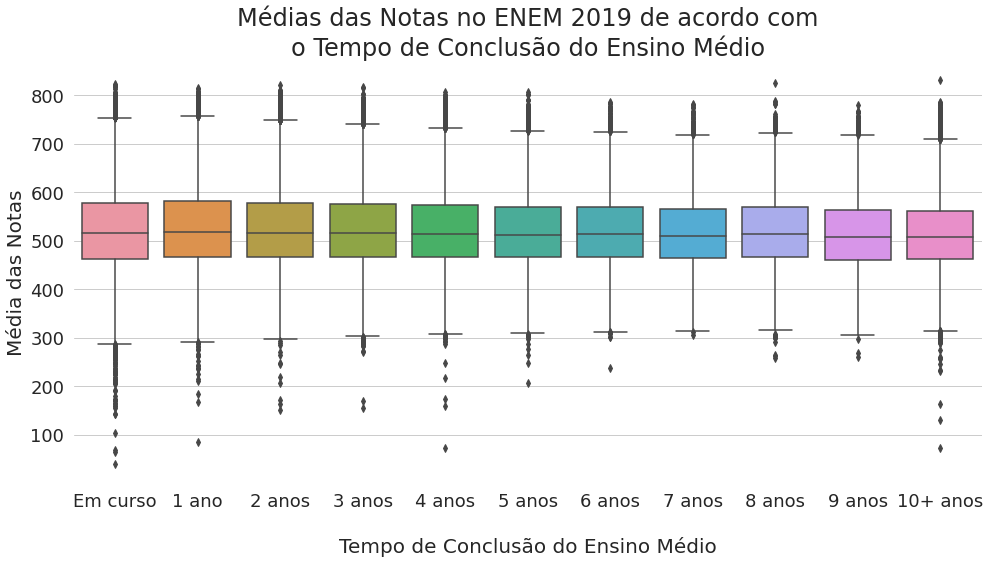

In [ ]:
sns.set(rc={"figure.figsize":(14, 8)})
sns.set_style('whitegrid')

fig = sns.boxplot(
    x=tpconcluiu_presentes[tpconcluiu_presentes['NU_NOTA_MEDIA']!=0.0].loc[:,'TP_ANO_CONCLUIU'].map(TP_ANO_CONCLUIU_map),
    y=tpconcluiu_presentes[tpconcluiu_presentes['NU_NOTA_MEDIA']!=0.0].loc[:,'NU_NOTA_MEDIA'],
    data=tpconcluiu_presentes,
    order=list(TP_ANO_CONCLUIU_map.values())
)

fig.axes.set_title('Médias das Notas no ENEM 2019 de acordo com\no Tempo de Conclusão do Ensino Médio',fontsize=24)
fig.set_xlabel('\nTempo de Conclusão do Ensino Médio',fontsize=20)
fig.set_ylabel('Média das Notas',fontsize=20)
fig.tick_params(labelsize=18)
sns.despine(left=True, bottom=True)
plt.tight_layout()

In [ ]:
# Salvando Figura
fig_name = 'conclusao_media_box'
fig_folder = 'Conclusao'
fig_path = f'/content/drive/MyDrive/Colab Notebooks/IC_Data_Science_ENEM/Imagens/{fig_folder}/{fig_name}.png'
fig.figure.savefig(fig_path)

Subplots

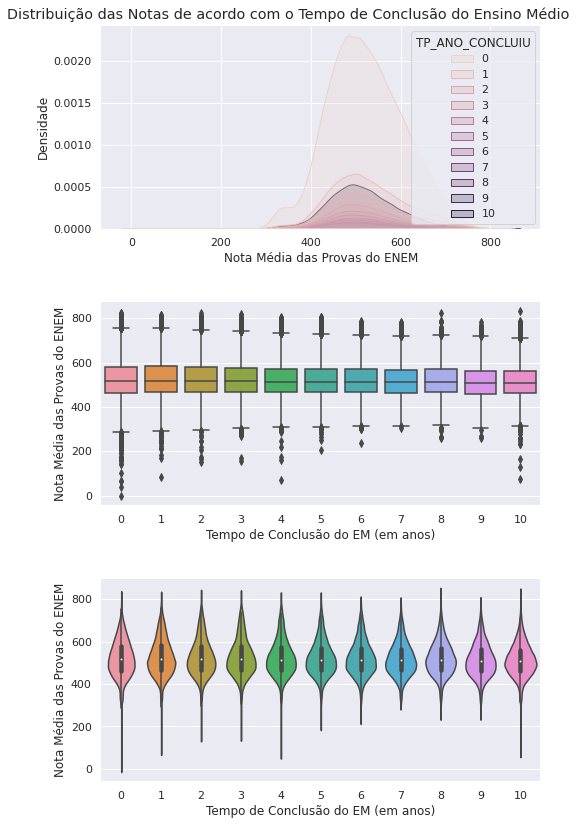

In [ ]:
f, axes = plt.subplots(3, 1, figsize=(8, 12))
sns.despine(left=True, top=True)
f.suptitle('Distribuição das Notas de acordo com o Tempo de Conclusão do Ensino Médio')

# Estimativa de Densidade de Kernel (KDE) entre as notas 
sns.kdeplot(
    x=tpconcluiu_presentes['NU_NOTA_MEDIA'], 
    hue=tpconcluiu_presentes['TP_ANO_CONCLUIU'],
    fill=True,
    shade=True,
    ax=axes[0]
)
axes[0].set_title('')
axes[0].set_xlabel('Nota Média das Provas do ENEM')
axes[0].set_ylabel('Densidade')

# Boxplot comparando a distribuição de notas entre os diferentes tempos de conclusão
sns.boxplot(
    y=tpconcluiu_presentes['NU_NOTA_MEDIA'],
    x=tpconcluiu_presentes['TP_ANO_CONCLUIU'],
    ax=axes[1]
)
axes[1].set_title('')
axes[1].set_xlabel('Tempo de Conclusão do EM (em anos)')
axes[1].set_ylabel('Nota Média das Provas do ENEM')

# Plot "violino"
sns.violinplot(
    y=tpconcluiu_presentes['NU_NOTA_MEDIA'],
    x=tpconcluiu_presentes['TP_ANO_CONCLUIU'],
    ax=axes[2]
)
axes[2].set_title('')
axes[2].set_xlabel('Tempo de Conclusão do EM (em anos)')
axes[2].set_ylabel('Nota Média das Provas do ENEM')

# Adicionar espaço entre os plots
plt.tight_layout(pad=3)

In [ ]:
# Salvando Figura
fig_name = 'conclusao_kde-box-violin'
fig_path = f'/content/drive/MyDrive/Colab Notebooks/IC_Data_Science_ENEM/Imagens/{fig_name}.png'
f.savefig(fig_path)

Teste

In [ ]:
df[df['NU_ANO']==2019].groupBy('TP_ANO_CONCLUIU') \
.agg({'NU_NOTA_MEDIA': 'mean'}) \
.orderBy('TP_ANO_CONCLUIU', ascending=False) \
.show()

+---------------+------------------+
|TP_ANO_CONCLUIU|avg(NU_NOTA_MEDIA)|
+---------------+------------------+
|             10| 514.0357992701462|
|              9| 515.7729752970915|
|              8| 521.1945634856702|
|              7| 520.1234592979018|
|              6| 521.1036475883946|
|              5| 523.0897428784622|
|              4| 524.3443403873962|
|              3|  527.877868265679|
|              2| 527.0920022148673|
|              1| 527.7355538255027|
|              0| 521.7557337182545|
+---------------+------------------+



In [ ]:
concluiu_media = df[df['NU_ANO']==2019].groupBy('TP_ANO_CONCLUIU') \
.agg({'NU_NOTA_MEDIA': 'mean'}) \
.orderBy('TP_ANO_CONCLUIU', ascending=True) \
.toPandas()

In [ ]:
# Criando interpolação

x = concluiu_media['TP_ANO_CONCLUIU']
y = concluiu_media['avg(NU_NOTA_MEDIA)']
z = np.polyfit(x, y, 1)
f = np.poly1d(z)

In [ ]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        name = 'Interpolação',
        mode = 'lines',
        x = concluiu_media['TP_ANO_CONCLUIU'].map(TP_ANO_CONCLUIU_map),
        y = f(concluiu_media['TP_ANO_CONCLUIU']),
        line = dict(
            color='rgb(230, 57, 70, 1)',
            shape='spline',
            dash='dash',
            width=1.5,
        ),
    )
)
fig.add_trace(
    go.Scatter(
        name = 'Desistência',
        x = concluiu_media['TP_ANO_CONCLUIU'].map(TP_ANO_CONCLUIU_map),
        y = concluiu_media['avg(NU_NOTA_MEDIA)'],        
        mode='markers+text',
        text = concluiu_media['avg(NU_NOTA_MEDIA)'],
        texttemplate='<b>%{text:.1f}</b>', 
        textposition='top center', 
        textfont={'size': 20, 'color':'#013a63'},
        marker=dict(
            symbol='x',
            size=15,
            color='#013a63'
        )
    ),
)

fig.update_layout(
    title = dict(
        text='Média das Notas por Tempo de Conclusão do Ensino Médio',
        font=dict(size=24)
    ),
    yaxis = dict(
        title = dict(
            text='Média das Notas',
            font=dict(size=20)
        ),
        tickfont = dict(size=18),
        linecolor = '#BCCCDC',
    ),
    xaxis = dict(
        title = dict(
            text='Tempo de Conclusão do Ensino Médio',
            font=dict(size=20)
        ),
        tickfont = dict(size=18),
        linecolor = '#BCCCDC'
    ),
    showlegend=False,
    autosize = True,
    margin = {'l':1, 'r':1, 't':35, 'b':1},
    plot_bgcolor = 'white',
    overwrite=False
)

fig.show()

In [ ]:
# Salvando Figura
fig_name = 'conclusao_media_scatter'
fig_folder = 'Conclusao'
fig_path = f'/content/drive/MyDrive/Colab Notebooks/IC_Data_Science_ENEM/Imagens/{fig_folder}/{fig_name}.png'
fig.write_image(fig_path)

### Testes Estatísticos

Teste de Simetria

In [ ]:
# Testando a simetria ou distorção da normalidade (skewness)
# CHEATSHEET: Varia entre -1 e 1. Quanto mais próximo de zero, mas simétrica e fiel a uma curva normal.
#             Quanto mais próximo dos extremos, mas assimétrica e distorcidade a amostra.
print('Medida de Distorção Assimétrica em Relação à Média Amostral das Categorias')
for tempo in tpconcluiu_presentes['TP_ANO_CONCLUIU'].unique().tolist():
  print('\tTempo {}: {:.4g}'.format(tempo, tpconcluiu_presentes[tpconcluiu_presentes['TP_ANO_CONCLUIU']==tempo].loc[:,'NU_NOTA_MEDIA'].skew()))

Medida de Distorção Assimétrica em Relação à Média Amostral das Categorias
	Tempo 0: 0.1555
	Tempo 10: 0.2614
	Tempo 1: 0.3522
	Tempo 2: 0.4385
	Tempo 5: 0.4761
	Tempo 4: 0.4744
	Tempo 3: 0.4722
	Tempo 6: 0.4219
	Tempo 8: 0.2971
	Tempo 7: 0.3843
	Tempo 9: 0.3493


Média e Desvio Padrão das Amostras

In [ ]:
# Média e Desvio Padrão das Amostras
print('Média e Desvio Padrão da Amostra\n')
for tempo in tpconcluiu_presentes['TP_ANO_CONCLUIU'].unique().tolist():
  categoria_tempo = tpconcluiu_presentes[tpconcluiu_presentes['TP_ANO_CONCLUIU']==tempo].loc[:,'NU_NOTA_MEDIA']
  print('\nTempo: {}'.format(tempo))
  print('\tMédia: {:.4g}\tDesvio Padrão: {:.4g}'.format(categoria_tempo.mean(), categoria_tempo.std()))

Média e Desvio Padrão da Amostra


Tempo: 0
	Média: 521.5	Desvio Padrão: 84.51

Tempo: 10
	Média: 513.9	Desvio Padrão: 75.67

Tempo: 1
	Média: 527.5	Desvio Padrão: 85.87

Tempo: 2
	Média: 526.9	Desvio Padrão: 85.88

Tempo: 5
	Média: 522.4	Desvio Padrão: 80.39

Tempo: 4
	Média: 524.6	Desvio Padrão: 83.22

Tempo: 3
	Média: 527.1	Desvio Padrão: 85.62

Tempo: 6
	Média: 522.8	Desvio Padrão: 79.53

Tempo: 8
	Média: 520.6	Desvio Padrão: 76.94

Tempo: 7
	Média: 518.8	Desvio Padrão: 77.03

Tempo: 9
	Média: 514.2	Desvio Padrão: 77.42


Testes de Normalidade

In [ ]:
## Teste de Normalidade (Shapiro, D'Agostino e Anderson-Darling)

# Pelos gráficos, a variável TP_SEXO aparenta
# estar próximo de uma distribuição normal

# H0: a amostra é proveniente de uma distribuição normal
# H1: a amostra não é proveniente de uma distribuição normal
alpha = 0.05  # 5% de significância

# Teste de Shapiro-Wilk
print('\tTeste de Shapiro-Wilk\n')

for tempo in tpconcluiu_presentes['TP_ANO_CONCLUIU'].unique().tolist():
  categoria_tempo = tpconcluiu_presentes[tpconcluiu_presentes['TP_ANO_CONCLUIU']==tempo].loc[:,'NU_NOTA_MEDIA']
  stat, p = shapiro(categoria_tempo)

  print(f'\nCategoria: {tempo}')
  print('Stat: {:.3g}\tp: {:.3g}'.format(stat, p))
  if p >= alpha:
    print('Falhou em Rejeitar H0 -> Distribuição Normal\n\n') 
  else:
    print('Pode-se Rejeitar H0 -> Distribuição Não-Normal\n\n')

# Teste de D'Agostino
print('\tTeste de D\'Agostino\n')

for tempo in tpconcluiu_presentes['TP_ANO_CONCLUIU'].unique().tolist():
  categoria_tempo = tpconcluiu_presentes[tpconcluiu_presentes['TP_ANO_CONCLUIU']==tempo].loc[:,'NU_NOTA_MEDIA']
  stat, p = normaltest(categoria_tempo)

  print(f'\nCategoria: {tempo}')
  print('Stat: {:.3g}\tp: {:.3g}'.format(stat, p))
  if p >= alpha:
    print('Falhou em Rejeitar H0 -> Distribuição Normal\n\n') 
  else:
    print('Pode-se Rejeitar H0 -> Distribuição Não-Normal\n\n')

# Teste de Anderson-Darling
print('\tTeste de Anderson-Darling\n')

for tempo in tpconcluiu_presentes['TP_ANO_CONCLUIU'].unique().tolist():
  categoria_tempo = tpconcluiu_presentes[tpconcluiu_presentes['TP_ANO_CONCLUIU']==tempo].loc[:,'NU_NOTA_MEDIA']
  stat, p, cv = anderson(categoria_tempo)

  print(f'\nCategoria: {tempo}')
  AD = stat*(1 + (.75/50) + 2.25/(50**2))  
  print("Adjusted A^2 = ", AD)

  if AD >= .6:
      p = math.exp(1.2937 - 5.709*AD - .0186*(AD**2))
  elif AD >=.34:
      p = math.exp(.9177 - 4.279*AD - 1.38*(AD**2))
  elif AD >.2:
      p = 1 - math.exp(-8.318 + 42.796*AD - 59.938*(AD**2))
  else:
      p = 1 - math.exp(-13.436 + 101.14*AD - 223.73*(AD**2))
  
  print('p[5%]: {:.3g}'.format(p))
  if p >= alpha:
    print('Falhou em Rejeitar H0 -> Distribuição Normal\n\n') 
  else:
    print('Pode-se Rejeitar H0 -> Distribuição Não-Normal\n\n')

	Teste de Shapiro-Wilk


Categoria: 0
Stat: 0.996	p: 0
Pode-se Rejeitar H0 -> Distribuição Não-Normal



Categoria: 10
Stat: 0.994	p: 4.48e-34
Pode-se Rejeitar H0 -> Distribuição Não-Normal



Categoria: 1
Stat: 0.988	p: 0
Pode-se Rejeitar H0 -> Distribuição Não-Normal



Categoria: 2
Stat: 0.984	p: 0
Pode-se Rejeitar H0 -> Distribuição Não-Normal



Categoria: 5
Stat: 0.983	p: 1.96e-34
Pode-se Rejeitar H0 -> Distribuição Não-Normal



Categoria: 4
Stat: 0.982	p: 6.56e-40
Pode-se Rejeitar H0 -> Distribuição Não-Normal



Categoria: 3
Stat: 0.981	p: 5.61e-45
Pode-se Rejeitar H0 -> Distribuição Não-Normal



Categoria: 6
Stat: 0.986	p: 2.66e-28
Pode-se Rejeitar H0 -> Distribuição Não-Normal



Categoria: 8
Stat: 0.993	p: 4.63e-16
Pode-se Rejeitar H0 -> Distribuição Não-Normal



Categoria: 7
Stat: 0.989	p: 2.35e-23
Pode-se Rejeitar H0 -> Distribuição Não-Normal



Categoria: 9
Stat: 0.991	p: 8.85e-18
Pode-se Rejeitar H0 -> Distribuição Não-Normal


	Teste de D'Agostino


Categoria: 0
Sta

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning:

p-value may not be accurate for N > 5000.

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning:

p-value may not be accurate for N > 5000.

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning:

p-value may not be accurate for N > 5000.

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning:

p-value may not be accurate for N > 5000.

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning:

p-value may not be accurate for N > 5000.

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning:

p-value may not be accurate for N > 5000.

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning:

p-value may not be accurate for N > 5000.

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning:

p-value may not be accurate


Categoria: 0
Adjusted A^2 =  253.31670521566798
p[5%]: 0
Pode-se Rejeitar H0 -> Distribuição Não-Normal



Categoria: 10
Adjusted A^2 =  67.14097149994757
p[5%]: 4.78e-203
Pode-se Rejeitar H0 -> Distribuição Não-Normal



Categoria: 1
Adjusted A^2 =  206.64857700260794
p[5%]: 0
Pode-se Rejeitar H0 -> Distribuição Não-Normal



Categoria: 2
Adjusted A^2 =  175.6196319553544
p[5%]: 0
Pode-se Rejeitar H0 -> Distribuição Não-Normal



Categoria: 5
Adjusted A^2 =  62.769028572203894
p[5%]: 1.28e-187
Pode-se Rejeitar H0 -> Distribuição Não-Normal



Categoria: 4
Adjusted A^2 =  91.7846320394719
p[5%]: 8.73e-296
Pode-se Rejeitar H0 -> Distribuição Não-Normal



Categoria: 3
Adjusted A^2 =  134.8951434568412
p[5%]: 0
Pode-se Rejeitar H0 -> Distribuição Não-Normal



Categoria: 6
Adjusted A^2 =  40.21641340748716
p[5%]: 6.09e-113
Pode-se Rejeitar H0 -> Distribuição Não-Normal



Categoria: 8
Adjusted A^2 =  13.178226624323692
p[5%]: 3.06e-34
Pode-se Rejeitar H0 -> Distribuição Não-Normal



Ca

Teste de Igualdade das Variâncias

In [ ]:
# Teste de Levene / Brown-Forsythe

# H0: As variâncias das amostras são iguais
# H1: Pelo menos uma variância é diferente

# Center: median. Por conta do valor de assimetria (skewness) das amostras
print('\tTeste de Levene (Brown-Forsythe)\n')

categorias_tempo = list()
for tempo in tpconcluiu_presentes['TP_ANO_CONCLUIU'].unique().tolist():
  categorias_tempo.append(tpconcluiu_presentes[tpconcluiu_presentes['TP_ANO_CONCLUIU']==tempo].loc[:,'NU_NOTA_MEDIA'])

stat, p = levene(*categorias_tempo, center='median')

print('Stat: {:.3g}\tp = {:.3g}'.format(stat, p))
if p >= alpha:
  print('Falhou em Rejeitar H0 -> Variâncias Iguais\n\n') 
else:
  print('Pode-se Rejeitar H0 -> Variâncias Diferentes\n\n')

	Teste de Levene (Brown-Forsythe)

Stat: 122	p = 1.08e-254
Pode-se Rejeitar H0 -> Variâncias Diferentes




In [ ]:
## NEMEYI

## Dados Socioeconômicos

### Nível de Escolaridade do(a) Pai/Mãe/responsável

In [ ]:
# Dicionário de Respostas de Q001 e Q002 do formulário
q001_q002_map = {
    'A': 'Nunca estudou',
    'B': 'Sem Ensino Fundamental I',
    'C': 'Ensino Fundamental I',
    'D': 'Ensino Fundamental II',
    'E': 'Ensino Médio',
    'F': 'Ensino Superior',
    'G': 'Pós-graduação',
    'H': 'Não sei'
}

Escolaridade do Pai/Homem Responsável

In [ ]:
q001_media = df.groupBy('Q001') \
.agg({'NU_NOTA_MEDIA':'avg', 'Q001':'count'}) \
.toPandas()

In [ ]:
q001_media = q001_media.sort_values('avg(NU_NOTA_MEDIA)', ascending=False).reset_index(drop=True)
q001_media = q001_media.rename(columns={
    'avg(NU_NOTA_MEDIA)': 'Média',
    'count(Q001)': 'Inscritos'
})
q001_media['Q001'] = q001_media['Q001'].map(q001_q002_map)

In [ ]:
q001_media

,Q001,Inscritos,Média
0,Pós-graduação,671617,603.207275
1,Ensino Superior,1147385,585.633998
2,Ensino Médio,4203220,538.613744
3,Ensino Fundamental II,1993929,519.087319
4,Ensino Fundamental I,2452745,509.842841
5,Não sei,1518712,500.289248
6,Sem Ensino Fundamental I,3868143,494.459893
7,Nunca estudou,995131,474.855482


In [ ]:
## Ver localidade predominante dos níveis de escolaridade

Nível de Escolaridade da Mãe/Mulher Responsável

In [ ]:
q002_media = df.groupBy('Q002') \
.agg({'NU_NOTA_MEDIA':'avg', 'Q002':'count'}) \
.toPandas()

In [ ]:
q002_media = q002_media.sort_values('avg(NU_NOTA_MEDIA)', ascending=False).reset_index(drop=True)
q002_media = q002_media.rename(columns={
    'avg(NU_NOTA_MEDIA)': 'Média',
    'count(Q002)': 'Inscritos'
})
q002_media['Q002'] = q002_media['Q002'].map(q001_q002_map)

In [ ]:
# Reordenando de acordo com Q001 para não bagunçar o gráfico
q002_media = q002_media.set_index('Q002')
q002_media = q002_media.reindex(index=q001_media['Q001'])
q002_media = q002_media.reset_index() \
.rename(columns={'Q001': 'Q002'})

In [ ]:
q002_media

,Q002,Inscritos,Média
0,Pós-graduação,1176582,584.103857
1,Ensino Superior,1562034,572.569731
2,Ensino Médio,5234883,530.239316
3,Ensino Fundamental II,2282140,510.683901
4,Ensino Fundamental I,2379717,502.959409
5,Não sei,542294,486.338300
6,Sem Ensino Fundamental I,2972364,489.745313
7,Nunca estudou,700868,470.196584


Comparando a distribuição de cada um em gráfico de barras

In [ ]:
fig = go.Figure()

fig.add_trace(
    go.Bar(
        name = 'Mãe',
        x = q002_media['Inscritos'],
        y = q002_media.Q002,
        offsetgroup = 1,
        text = q002_media['Inscritos'],
        marker = dict(color = 'rgb(230, 57, 70, 1)',),
        orientation='h'
    )
)
fig.add_trace(
    go.Bar(
        name = 'Pai',
        x = q001_media['Inscritos'],
        y = q001_media.Q001,
        offsetgroup = 0,
        text = q001_media['Inscritos'],
        marker = dict(color = '#013a63',),
        orientation='h'
    )
)
      
fig.update_layout(
    title = dict(
        text='Inscritos do ENEM entre 2017 e 2019 pelo Nível<br> de Escolaridade dos Responsáveis',
        font=dict(size=24)
    ),
    yaxis = dict(
        title = dict(
            text='Nível de Escolaridade',
            font=dict(size=20)
        ),
        tickfont = dict(size=18)
    ),
    xaxis = dict(
        title = dict(
            text='Quantidade de Inscritos',
            font=dict(size=20)
        ),
        tickfont = dict(size=18)
    ),
    legend=dict(
        font=dict(size=16),
        title=dict(
            text='Responsável',
            font=dict(size=18)
        ),
        xanchor='right',
        x=0.99,
        yanchor='top',
        y=0.99,
        traceorder='reversed'
    ),
    autosize=True,
    margin=dict(l=1, r=10, t=70, b=5),
    plot_bgcolor='white',
)

fig.show()

In [ ]:
# Salvando Figura
fig_name = 'esc_pai_mae-hbar.png'
fig_folder = 'Escolaridade'
fig_path = f'/content/drive/MyDrive/Colab Notebooks/IC_Data_Science_ENEM/Imagens/{fig_folder}/{fig_name}'
fig.write_image(fig_path)

Comparando o impacto do nível de escolaridade de homem/pai responsável e mãe/mulher responsável

In [ ]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=q001_media.Q001, y=q001_media['Média'],
        mode='lines+markers+text',
        line=dict(color='#013a63', width=4),
        name='Pai',
        line_shape='linear',
    )
)
fig.add_trace(
    go.Scatter(
        x=q002_media.Q002, y=q002_media['Média'],
        mode='lines+markers+text',
        line=dict(color='rgb(230, 57, 70, 1)', width=4),
        name='Mãe',
        line_shape='linear',
    )
)

fig.update_layout(
    plot_bgcolor = '#FFFFFF',
    title = dict(
        text='Média de Notas por Nível de Escolaridade do Pai e da Mãe',
        font=dict(size=24)
    ),
    legend = dict(
        font=dict(size=16),
        title=dict(
            text='Responsável',
            font=dict(size=18)
        ),
        yanchor='top',
        y=0.99,
        xanchor='right',
        x=1.0
    ),
    xaxis = dict(
        title = dict(
            text='Nível de Escolaridade',
            font=dict(size=20)
        ),
        tickfont=dict(size=18),
        linecolor='#BCCCDC'
    ),
    yaxis = dict(
        title = dict(
            text='Média das Notas',
            font=dict(size=20)
        ),
        tickfont=dict(size=18),
        linecolor='#BCCCDC'
    ),
    autosize=True,
    margin={'l':1, 'r':1, 't':35, 'b':1},
    overwrite=False
)

fig.show()

In [ ]:
# Salvando Figura
fig_name = 'esc_pai_mae-line2.png'
fig_folder = 'Escolaridade'
fig_path = f'/content/drive/MyDrive/Colab Notebooks/IC_Data_Science_ENEM/Imagens/{fig_folder}/{fig_name}'
fig.write_image(fig_path)

Desistência

In [ ]:
q001_temp = df.groupBy('Q001') \
.pivot('TP_PRESENCA') \
.count() \
.toPandas()

q002_temp = df.groupBy('Q002') \
.pivot('TP_PRESENCA') \
.count() \
.toPandas()

In [ ]:
q001_temp['Porcentagem'] = np.round(q001_temp['0']/(q001_temp['0']+q001_temp['1'])*100, 2)
q002_temp['Porcentagem'] = np.round(q002_temp['0']/(q002_temp['0']+q002_temp['1'])*100, 2)
q001_temp = q001_temp.sort_values('Porcentagem').reset_index(drop=True)
q002_temp = q002_temp.sort_values('Porcentagem').reset_index(drop=True)

In [ ]:
q001_temp[['Q001', 'Porcentagem']], q002_temp[['Q002','Porcentagem']]

(  Q001  Porcentagem
 0    G        16.30
 1    F        18.88
 2    E        25.44
 3    D        29.18
 4    C        31.70
 5    H        34.67
 6    B        36.77
 7    A        39.58,   Q002  Porcentagem
 0    G        17.51
 1    F        20.21
 2    E        26.74
 3    D        31.63
 4    C        34.20
 5    H        36.95
 6    B        38.58
 7    A        41.80)

In [ ]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=q001_temp.Q001.map(q001_q002_map), y=q001_temp['Porcentagem'],
        mode='lines+markers+text',
        line=dict(color='#013a63', width=4),
        name='Pai',
        line_shape='linear',
    )
)
fig.add_trace(
    go.Scatter(
        x=q002_temp.Q002.map(q001_q002_map), y=q002_temp['Porcentagem'],
        mode='lines+markers+text',
        line=dict(color='rgb(230, 57, 70, 1)', width=4),
        name='Mãe',
        line_shape='linear',
    )
)

fig.update_layout(
    plot_bgcolor = '#FFFFFF',
    title = dict(
        text='Desistência por Nível de Escolaridade do Pai e da Mãe',
        font=dict(size=24)
    ),
    legend = dict(
        font=dict(size=16),
        title=dict(
            text='Responsável',
            font=dict(size=18)
        ),
        yanchor='top',
        y=0.3,
        xanchor='right',
        x=1.0,
        traceorder='reversed'
    ),
    xaxis = dict(
        title = dict(
            text='Nível de Escolaridade',
            font=dict(size=20)
        ),
        tickfont=dict(size=18),
        linecolor='#BCCCDC'
    ),
    yaxis = dict(
        title = dict(
            text='Desistentes',
            font=dict(size=20)
        ),
        tickfont=dict(size=18),
        ticksuffix = '%',
        linecolor='#BCCCDC'
    ),
    autosize=True,
    margin={'l':1, 'r':1, 't':35, 'b':1},
    overwrite=False
)

fig.show()

In [ ]:
# Salvando Figura
fig_name = 'esc_desistencia_line.png'
fig_folder = 'Escolaridade'
fig_path = f'/content/drive/MyDrive/Colab Notebooks/IC_Data_Science_ENEM/Imagens/{fig_folder}/{fig_name}'
fig.write_image(fig_path)

### Renda Familiar

Para diminuir a quantidade de categorias, os grupos D e F serão incorporados aos grupos C e E, respectivamente.

In [ ]:
# Mapa de Respostas da Q006 (em salários-mínimos)
q006_map = {
    'A': '0',
    'B': '0 - 1', 
    'C': '1 - 2',
    'E': '2 - 3',
    'G': '3 - 4', 
    'H': '4 - 5',
    'I': '5 - 6',
    'J': '6 - 7',
    'K': '7 - 8',
    'L': '8 - 9',
    'M': '9 - 10',
    'N': '10 - 12', 
    'O': '12 - 15',
    'P': '15 - 20',
    'Q': 'Mais de 20'
}

In [ ]:
df_q006 = df[df['NU_ANO']==2019].select('Q006', 'NU_NOTA_MEDIA').toPandas()

In [ ]:
df_q006 = df_q006[df_q006['NU_NOTA_MEDIA']>0]

In [ ]:
df_q006['Q006'] = df_q006['Q006'].replace(['D','F'],['C','E'])

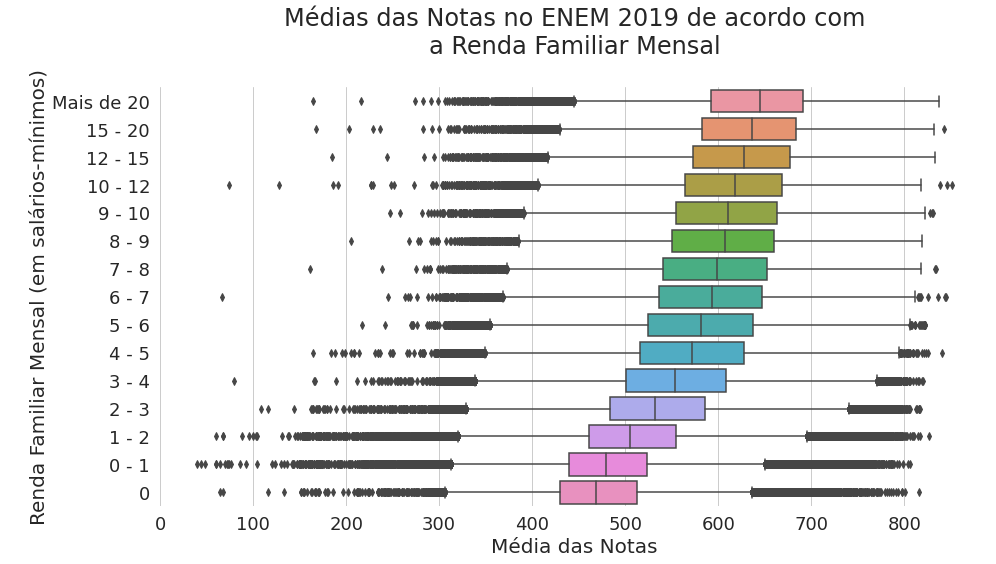

In [ ]:
sns.set(rc={"figure.figsize":(14, 8)})
sns.set_style('whitegrid')

fig = sns.boxplot(
    y=df_q006[df_q006['NU_NOTA_MEDIA']!=0.0].loc[:,'Q006'].map(q006_map),
    x=df_q006[df_q006['NU_NOTA_MEDIA']!=0.0].loc[:,'NU_NOTA_MEDIA'],
    data=df_q006,
    orient='h',
    order=list(q006_map.values())[::-1] # reversed list
)

fig.axes.set_title('Médias das Notas no ENEM 2019 de acordo com\na Renda Familiar Mensal\n',fontsize=24)
fig.set_ylabel('\nRenda Familiar Mensal (em salários-mínimos)',fontsize=20)
fig.set_xlabel('Média das Notas',fontsize=20)
fig.tick_params(labelsize=18)
sns.despine(left=True, bottom=True)
plt.tight_layout()

In [ ]:
fig_name = 'renda_media_box.png'
fig_folder = 'Renda'
fig_path = f'/content/drive/MyDrive/Colab Notebooks/IC_Data_Science_ENEM/Imagens/{fig_folder}/{fig_name}'
fig.figure.savefig(fig_path)

Obtendo a distribuição das categorias de renda familiar mensal dos inscritos em geral

In [ ]:
q006_count = df.groupBy('Q006') \
.count() \
.toPandas()

In [ ]:
q006_count

,Q006,count
0,K,182340
1,F,775316
2,Q,169163
3,E,1482805
4,B,4377846
5,M,129574
6,L,143475
7,D,1722648
8,O,139658
9,C,4291047


In [ ]:
q006_count.loc[q006_count['Q006']=='C', 'count'] = q006_count[q006_count['Q006']=='C'].values.tolist()[0][1] \
+ q006_count[q006_count['Q006']=='D'].values.tolist()[0][1]
q006_count = q006_count.loc[(q006_count['Q006']!='D')]

q006_count.loc[q006_count['Q006']=='E', 'count'] = q006_count[q006_count['Q006']=='E'].values.tolist()[0][1] \
+ q006_count[q006_count['Q006']=='F'].values.tolist()[0][1]
q006_count = q006_count.loc[(q006_count['Q006']!='F')]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
q006_count = q006_count.sort_values('Q006', ascending=True).reset_index(drop=True)
#q006_media['Q006'] = q006_media['Q006'].map(q006_map)

In [ ]:
q006_count.head()

,Q006,count
0,A,732572
1,B,4377846
2,C,6013695
3,E,2258121
4,G,1006094


In [ ]:
q006_count['Porcentagem'] = np.round(q006_count['count']/np.sum(q006_count['count'])*100, 2)

In [ ]:
fig = go.Figure()

fig.add_trace(
    go.Bar(
        name = 'Inscritos',
        x = q006_count['count'],
        y = q006_count.Q006.map(q006_map),
        offsetgroup = 0,
        text = q006_count['Porcentagem'],
        textposition = 'outside',
        texttemplate = '<b>%{text}%</b>',
        textfont = dict(color='#013a63', size=20),
        marker = dict(
            color = '#013a63',
        ),
        orientation='h'
    )
)
      
fig.update_layout(
    title = dict(
        text='Inscritos do ENEM entre 2017 e 2019 de acordo<br>com a Renda Familiar Mensal',
        font=dict(size=24),
        pad=dict(b=30)
    ),
    yaxis = dict(
        title = dict(
            text='Renda Mensal (em salários mínimos)',
            font=dict(size=20)
        ),
        tickfont = dict(size=18)
    ),
    xaxis = dict(
        title = dict(
            text='Quantidade de Inscritos',
            font=dict(size=20)
        ),
        tickfont = dict(size=18),
        range = [0, 6.9e6]
    ),
    legend=dict(
        font=dict(size=16),
        title=dict(
            text='Responsável',
            font=dict(size=18)
        ),
        xanchor='right',
        x=0.99,
        yanchor='top',
        y=0.99
    ),
    autosize=True,
    margin=dict(l=1, r=10, t=70, b=5),
    plot_bgcolor='white',
)

fig.show()

In [ ]:
# Salvando Figura
fig_name = 'renda_count_hbar.png'
fig_folder = 'Renda'
fig_path = f'/content/drive/MyDrive/Colab Notebooks/IC_Data_Science_ENEM/Imagens/{fig_folder}/{fig_name}'
fig.write_image(fig_path)

Nota média por renda familiar mensal

In [ ]:
q006_media = df.groupBy('Q006') \
.mean('NU_NOTA_MEDIA') \
.toPandas()

In [ ]:
q006_media.head()

,Q006,avg(NU_NOTA_MEDIA)
0,K,597.246880
1,F,544.477252
2,Q,639.790255
3,E,530.640924
4,B,484.675240


In [ ]:
q006_media.loc[q006_media['Q006']=='C', 'avg(NU_NOTA_MEDIA)'] = (q006_media[q006_media['Q006']=='C'].values.tolist()[0][1] \
+ q006_media[q006_media['Q006']=='D'].values.tolist()[0][1])/2
q006_media = q006_media.loc[(q006_media['Q006']!='D')]

q006_media.loc[q006_media['Q006']=='E', 'avg(NU_NOTA_MEDIA)'] = (q006_media[q006_media['Q006']=='E'].values.tolist()[0][1] \
+ q006_media[q006_media['Q006']=='F'].values.tolist()[0][1])/2
q006_media = q006_media.loc[(q006_media['Q006']!='F')]

In [ ]:
q006_media = q006_media.sort_values('Q006', ascending=True).reset_index(drop=True)
q006_media

,Q006,avg(NU_NOTA_MEDIA)
0,A,476.542288
1,B,484.675240
2,C,513.426589
3,E,537.559088
4,G,554.035045
5,H,568.743817
6,I,580.063783
7,J,590.612559
8,K,597.246880
9,L,604.924430


In [ ]:
# Plot de barras
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        name='Média',
        x=q006_media['avg(NU_NOTA_MEDIA)'], 
        y=q006_media.Q006.map(q006_map),
        mode='lines+markers+text',
        line=dict(color='#013a63', width=3),
        marker_symbol='x', 
        marker_size=15,
        marker_line_width=3, 
        marker_line_color='#013a63',  
        marker_color='#013a63',    
        line_shape='linear',
        text = q006_media['avg(NU_NOTA_MEDIA)'],
        textposition = 'top left',
        texttemplate = '<b>%{text:.0f}</b>',
        textfont=dict(size=20, color='#013a63')
    )
)


fig.update_layout(
    title = dict(
        text='Média de Notas dos Inscritos do ENEM<br>de acordo com a Renda Familiar Mensal',
        font=dict(size=24),
        yref='paper',
        yanchor='bottom',
        pad = dict(b=30),
        xanchor='center',
        x=0.5
    ),
    yaxis = dict(
        title= dict(
            text='Nível de Renda [em salários mínimos]',
            font=dict(size=20),
        ),
        tickfont=dict(size=16),
        linecolor='#BCCCDC',
    ),
    xaxis = dict(
        title = dict(
            text='Média de Notas',
            font=dict(size=20),
        ),
        tickfont=dict(size=16),
        range=[461,649],
        linecolor='#BCCCDC',
    ),
    autosize=True,
    margin=dict(l=1, r=1, t=50, b=1),
    plot_bgcolor='white'
)

fig.show()

In [ ]:
# Salvando Figura
fig_name = 'renda_media_line.png'
fig_folder = 'Renda'
fig_path = f'/content/drive/MyDrive/Colab Notebooks/IC_Data_Science_ENEM/Imagens/{fig_folder}/{fig_name}'
fig.write_image(fig_path)

In [ ]:
# Rankear a diferença entre maior e menor renda por Estado
# para comparar a desigualdade de educação por UF

Desistência por Renda Famliar Mensal

In [ ]:
q006_presenca = df.groupby('Q006') \
.pivot('TP_PRESENCA') \
.count() \
.toPandas()

In [ ]:
q006_presenca.loc[q006_presenca['Q006']=='C', ['0', '1']] = np.array(q006_presenca[q006_presenca['Q006']=='C'].values.tolist()[0][1:]) \
+ np.array(q006_presenca[q006_presenca['Q006']=='D'].values.tolist()[0][1:])
q006_presenca = q006_presenca.loc[(q006_presenca['Q006']!='D')]

q006_presenca.loc[q006_presenca['Q006']=='E', ['0', '1']] = np.array(q006_presenca[q006_presenca['Q006']=='E'].values.tolist()[0][1:]) \
+ np.array(q006_presenca[q006_presenca['Q006']=='F'].values.tolist()[0][1:])
q006_presenca = q006_presenca.loc[(q006_presenca['Q006']!='F')]

In [ ]:
q006_presenca['Desistencia'] = np.round(q006_presenca['0']/(q006_presenca['0']+q006_presenca['1'])*100, 2)
q006_presenca = q006_presenca.sort_values('Q006', ascending=True).reset_index(drop=True)
q006_presenca.head()

,Q006,0,1,Desistencia
0,A,265306,467266,36.22
1,B,1480579,2897267,33.82
2,C,2009401,4004294,33.41
3,E,642805,1615316,28.47
4,G,242223,763871,24.08


In [ ]:
fig = go.Figure()

fig.add_trace(
    go.Bar(
        name = 'Inscritos',
        x = q006_presenca['Desistencia'],
        y = q006_presenca.Q006.map(q006_map),
        offsetgroup = 0,
        text = q006_presenca['Desistencia'],
        textposition = 'outside',
        texttemplate = '<b>%{text}%</b>',
        textfont = dict(color='#013a63', size=20),
        marker = dict(
            color = '#013a63',
        ),
        orientation='h'
    )
)
      
fig.update_layout(
    title = dict(
        text='Desistência dos Inscritos do ENEM entre 2017 e 2019<br>de acordo com a Renda Familiar Mensal',
        font=dict(size=24),
        pad=dict(b=30)
    ),
    yaxis = dict(
        title = dict(
            text='Renda Mensal (em salários mínimos)',
            font=dict(size=20)
        ),
        tickfont = dict(size=18)
    ),
    xaxis = dict(
        title = dict(
            text='Proporção de Desistentes em Relação ao Total de Inscritos',
            font=dict(size=20)
        ),
        tickfont = dict(size=18),        
        ticksuffix='%',
        range=[15, 39],
    ),
    showlegend=False,
    legend=dict(
        font=dict(size=16),
        title=dict(
            text='Responsável',
            font=dict(size=18)
        ),
        xanchor='right',
        x=0.99,
        yanchor='top',
        y=0.99
    ),
    autosize=True,
    margin=dict(l=1, r=10, t=70, b=5),
    plot_bgcolor='white',
)

In [ ]:
# Salvando Figura
fig_name = 'renda_desistencia_hbar.png'
fig_folder = 'Renda'
fig_path = f'/content/drive/MyDrive/Colab Notebooks/IC_Data_Science_ENEM/Imagens/{fig_folder}/{fig_name}'
fig.write_image(fig_path)

### Disponibilidade de Internet

In [ ]:
q025_choropleth = df.groupBy('SG_UF_PROVA', 'CO_UF_PROVA') \
.pivot('Q025') \
.count() \
.toPandas()

In [ ]:
q025_choropleth['Porcentagem'] = np.round(q025_choropleth['A']/(q025_choropleth['A']+q025_choropleth['B'])*100, 2)
q025_choropleth = q025_choropleth.rename(columns={
    'SG_UF_PROVA': 'Estado',
    'CO_UF_PROVA': 'CodEstado',
    'A': 'SemInternet',
    'B': 'ComInternet'
}).sort_values('Porcentagem', ascending=False) \
.reset_index(drop=True)

In [ ]:
q025_choropleth.head()

,Estado,CodEstado,SemInternet,ComInternet,Porcentagem
0,PA,15,495914,385277,56.28
1,AP,16,70704,57647,55.09
2,AC,12,68925,57261,54.62
3,MA,21,381297,323009,54.14
4,AM,13,201206,190715,51.34


Exportando .csv para construção de choropleth

In [ ]:
csv_file = 'internet_uf'
csv_path = f'/content/drive/MyDrive/Colab Notebooks/IC_Data_Science_ENEM/Mapas/CSV/{csv_file}.csv'
q025_choropleth.to_csv(csv_path)

Média de Notas 

In [ ]:
sem_net = df[df['Q025']=='A'] \
.select('NU_NOTA_MEDIA') \
.where('TP_PRESENCA = 1') \
.toPandas()

In [ ]:
com_net = df[df['Q025']=='B'] \
.select('NU_NOTA_MEDIA') \
.where('TP_PRESENCA = 1') \
.toPandas()

In [ ]:
net_media = pd.concat([com_net['NU_NOTA_MEDIA'], sem_net['NU_NOTA_MEDIA']], axis=1)

In [ ]:
net_media.columns.values[0] = 'Com Internet'
net_media.columns.values[1] = 'Sem Internet'
net_media.head()

,Com Internet,Sem Internet
0,593.80,416.54
1,505.06,562.50
2,416.96,417.28
3,596.70,351.04
4,529.62,571.64


In [ ]:
net = net_media.melt(var_name='groups', value_name='vals')

In [ ]:
net[net['vals']==0.0].count()

groups    78
vals      78
dtype: int64

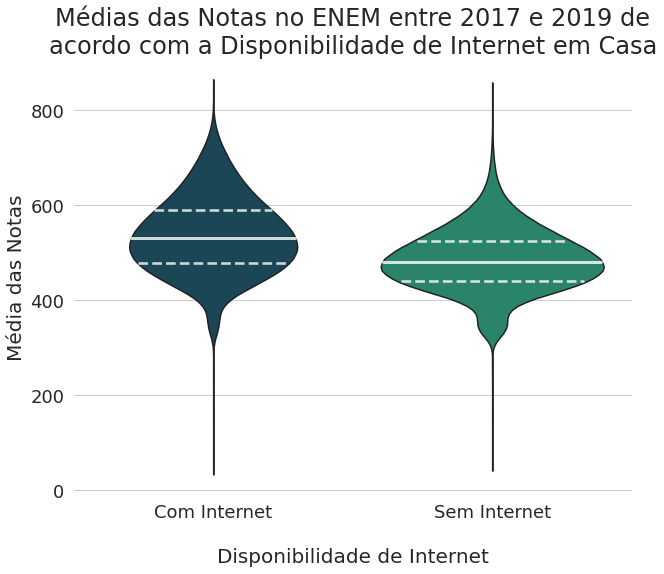

In [ ]:
sns.set(rc={"figure.figsize":(10, 8)})
sns.set_style('whitegrid')

fig = sns.violinplot(
    x=net[net['vals']>0.0].loc[:, 'groups'],
    y=net[net['vals']>0.0].loc[:, 'vals'], 
    data=net,
    inner='quartile',
    height=8,
    aspect=1.5,
    palette={'Com Internet': '#114b5f', 'Sem Internet': '#1a936f'}
)

for l in fig.lines:
    l.set_linestyle('dashed')
    l.set_linewidth(2.6)
    l.set_color('white')
    l.set_alpha(3.8)
for l in fig.lines[1::3]:
    l.set_linestyle('-')
    l.set_linewidth(3.0)
    l.set_color('white')
    l.set_alpha(0.8)

fig.axes.set_title('Médias das Notas no ENEM entre 2017 e 2019 de\nacordo com a Disponibilidade de Internet em Casa',fontsize=24)
fig.set_xlabel('\nDisponibilidade de Internet',fontsize=20)
fig.set_ylabel('Média das Notas',fontsize=20)
fig.tick_params(labelsize=18)
sns.despine(left=True, bottom=True)

Salvando Figura

In [ ]:
# Salvando figura
fig_name = 'internet_media_violin'
fig_folder = 'Internet'
fig_path = f'/content/drive/MyDrive/Colab Notebooks/IC_Data_Science_ENEM/Imagens/{fig_folder}/{fig_name}.png'
fig.figure.savefig(fig_path)

In [ ]:
q025_media = df.groupBy('Q025') \
.agg({'NU_NOTA_MEDIA': 'mean'}) \
.toPandas()

In [ ]:
q025_media = q025_media.sort_values('Q025', ascending=True).reset_index(drop=True)
q025_media.head()

,Q025,avg(NU_NOTA_MEDIA)
0,A,484.084596
1,B,536.384968


In [ ]:
fig = go.Figure()

fig.add_trace(
    go.Bar(
        name='Nota Média',
        x=q025_media.Q025.map({'A': 'Sem Internet', 'B': 'Com Internet'}),
        y=q025_media['avg(NU_NOTA_MEDIA)'],
        text=q025_media['avg(NU_NOTA_MEDIA)'],
        texttemplate='<b>%{text:.2f}</b>',
        textfont=dict(color=['#023e8a', '#3a5a40'], size=20),
        textposition='outside',
        marker_color=['#bee1e6', '#e9f5db'],
        marker_line_color=['#023e8a', '#3a5a40'],
        marker_line_width=3,
    )
)

fig.update_layout(
    title = dict(
        text='Média das Notas dos Inscritos do ENEM<br>de acordo com a Disponibilidade de Internet em Casa',
        font=dict(size=24),
        xanchor='center',
        x=0.5
    ),
    xaxis = dict(
        title=dict(
            text='Disponibilidade de Internet em Casa',
            font=dict(size=20),
        ),
        tickfont=dict(size=18),
        linecolor='#BCCCDC'
    ),
    yaxis=dict(
        title=dict(
            text='Média dasNotas nas Provas do ENEM',
            font=dict(size=20),
        ),
        tickfont=dict(size=18),
        linecolor='#BCCCDC',
        range=[300, 599]
    ),
    autosize=True,
    margin=dict(l=1, r=1, t=80, b=1),
    plot_bgcolor='white'
)

fig.show()

In [ ]:
# Salvando figura
fig_name = 'internet_media_bar'
fig_folder = 'Internet'
fig_path = f'/content/drive/MyDrive/Colab Notebooks/IC_Data_Science_ENEM/Imagens/{fig_folder}/{fig_name}.png'
fig.write_image(fig_path)

Desistência

In [ ]:
q025_presenca = df.groupBy('Q025') \
.pivot('TP_PRESENCA') \
.count() \
.toPandas()

In [ ]:
q025_presenca

,Q025,0,1
0,B,3473246,8811903
1,A,1624081,2941652


In [ ]:
q025_presenca = q025_presenca.sort_values('Q025', ascending=True).reset_index(drop=True)
q025_presenca['Desistencia'] = np.round(q025_presenca['0']/(q025_presenca['0']+q025_presenca['1'])*100, 2)
q025_presenca

,Q025,0,1,Desistencia
0,A,1624081,2941652,35.57
1,B,3473246,8811903,28.27


In [ ]:
q025_presenca.loc[q025_presenca['Q025']=='A', ['0', '1']].values.tolist()[0]

[1624081, 2941652]

In [ ]:
fig = make_subplots(
    rows=1, cols=2,
    specs=[[{'type':'domain'}, {'type':'domain'}]])

fig.add_trace(
    go.Pie(
        name='Sem Internet',
        labels = q025_presenca[['0', '1']].rename({'0': 'Ausentes', '1':'Presentes'}, axis=1).columns.tolist(), 
        values = q025_presenca.loc[q025_presenca['Q025']=='A', ['0', '1']].values.tolist()[0],
        hole=.3,
        pull=[0.0, 0.05],
        textinfo='label+percent',
        texttemplate='<b>%{label}<br>%{percent}</b>',
        textfont={'size':18, 'color': ['white', '#023e8a']},
        marker_colors=['#023e8a', '#eaf4f4'],
        marker_line_color='#023e8a',
        marker_line_width=1.5,
        title='Sem Internet<br>\n',
        titleposition='top center',
        titlefont={'size':20},        
    ), 1, 1
)
fig.add_trace(
    go.Pie(
        name='Com Internet',
        labels = q025_presenca[['0', '1']].rename({'0': 'Ausentes', '1':'Presentes'}, axis=1).columns.tolist(), 
        values = q025_presenca.loc[q025_presenca['Q025']=='B', ['0', '1']].values.tolist()[0],
        hole=.3,
        pull=[0.0, 0.05],
        textinfo='label+percent',
        texttemplate='<b>%{label}<br>%{percent}</b>',
        textfont={'size':18, 'color': ['white', '#3a5a40']},
        marker_colors=['#3a5a40', '#e9f5db'],
        marker_line_color='#3a5a40',
        marker_line_width=1.5,
        title='Com Internet<br>\n',
        titleposition='top center',
        titlefont={'size':20},        
    ), 1, 2
)

fig.update_layout(
    title = dict(
        text='Razão de Desistência dos Inscritos do ENEM<br>por Disponibilidade de Internet em Casa',
        font=dict(size=24),
        xref='paper',
        xanchor='center',
        yref='paper',
        yanchor='bottom',
        pad=dict(b=10),
        x=0.5
    ),
    showlegend=False,
    autosize=True,
    margin={'l':5, 'b':5, 't':70, 'r':5}
)

fig.show()

In [ ]:
# Salvando figura
fig_name = 'internet_desistencia_donut'
fig_folder = 'Internet'
fig_path = f'/content/drive/MyDrive/Colab Notebooks/IC_Data_Science_ENEM/Imagens/{fig_folder}/{fig_name}.png'
fig.write_image(fig_path)